# 🧠 Segmentação de Tumores Cerebrais com BraTS2020

**Objetivo do Projeto:** Desenvolver um pipeline completo de Deep Learning para segmentar tumores cerebrais a partir de imagens de ressonância magnética (MRI) do dataset BraTS2020.

**Fases do Pipeline:**
1.  **Configuração e Análise:** Preparação do ambiente, organização dos dados e análise exploratória.
2.  **Modelagem e Treinamento:** Implementação do modelo U-Net 3D, funções de perda e treinamento.
3.  **Validação e Inferência:** Avaliação do modelo e aplicação em novos dados.

---

###  Índice de Navegação

Navegue facilmente pelas seções do projeto clicando nos links abaixo.

#### Fase 1: Preparação e Análise
1. [Configuração do Ambiente](#configuracao)
2. [Organização e Divisão dos Dados](#organizacao-dados)
3. [Análise Exploratória e Seleção de Modalidades](#analise-exploratoria)
4. [Pipeline de Pré-processamento](#preprocessamento)

#### Fase 2: Modelagem e Treinamento
5. [Dataset e DataLoader](#dataset-loader)
6. [Modelo, Perda e Métricas](#modelo-perda-metricas)
7. [Treinamento e Validação](#treinamento)

#### Fase 3: Resultados e Inferência
8. [Análise de Resultados e Inferência](#resultados)

---

<a id="configuracao"></a>

## 1. Configuração do Ambiente

Nesta seção, vamos importar as bibliotecas essenciais e definir as configurações iniciais do projeto.

In [1]:
import os
import glob
import random
from typing import Dict, Union, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import numpy as np
from scipy.ndimage import zoom
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm

from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import nibabel as nib


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#  Configurações do Projeto
TRAIN_DATASET_PATH = '/content/drive/MyDrive/dataset/BraTS2020_TrainingData'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData'
TARGET_SIZE = (128, 128, 64) #(H, W, D) Dimensões finais do volume 3D após o pré-processamento

<a id="organizacao-dados"></a>

## 2. Organização e Divisão dos Dados

O primeiro passo é estruturar os caminhos para cada arquivo do dataset BraTS2020.
Em seguida, dividimos os dados de forma aleatória e estratificada para garantir que nosso modelo seja treinado e validado de forma robusta.

**Divisão dos Dados:**
- **Treino:** 68% dos pacientes
- **Validação:** 20% dos pacientes
- **Teste:** 12% dos pacientes

In [4]:
def organize_patients_from_folders(data_dir):
    """Organiza pacientes de forma simples e direta"""
    patients = {}

    # Buscar todas as pastas BraTS20
    pattern = os.path.join(data_dir, "**", "BraTS20*")
    patient_dirs = glob.glob(pattern, recursive=True)

    for patient_path in patient_dirs:
        if os.path.isdir(patient_path):
            patient_id = os.path.basename(patient_path)
            patients[patient_id] = {}

            # Buscar arquivos .nii na pasta do paciente
            for file in os.listdir(patient_path):
                if file.endswith('.nii'):
                    file_path = os.path.join(patient_path, file)
                    file_lower = file.lower()

                    if 'flair' in file_lower:
                        patients[patient_id]['flair'] = file_path
                    elif 't1ce' in file_lower:
                        patients[patient_id]['t1ce'] = file_path
                    elif 't1' in file_lower and 't1ce' not in file_lower:
                        patients[patient_id]['t1'] = file_path
                    elif 't2' in file_lower:
                        patients[patient_id]['t2'] = file_path
                    elif 'seg' in file_lower:
                        patients[patient_id]['seg'] = file_path

    return patients

def create_training_splits(data_dir):
    """Divisão  usando APENAS TrainingData"""

    # 1. Carregar APENAS dados de training
    train_patients_data = organize_patients_from_folders(data_dir)

    # 3. Divisão hierárquica com sklearn
    all_patients = list(train_patients_data.keys())

    print(f" Dataset: {len(all_patients)} pacientes do TrainingData")

    # Primeira divisão: separar validação (20%)
    train_and_test_ids, val_ids = train_test_split(
        all_patients,
        test_size=0.2,  # 20% para validação
        random_state=42,
        shuffle=True
    )

    # Segunda divisão: separar treino e teste (15% do restante)
    train_ids, test_ids = train_test_split(
        train_and_test_ids,
        test_size=0.15,  # 15% do 80% restante = ~12% total
        random_state=42,
        shuffle=True
    )

    print(f" Divisão realizada:")
    print(f"    Treino: {len(train_ids)} pacientes ({len(train_ids)/len(all_patients)*100:.1f}%)")
    print(f"    Validação: {len(val_ids)} pacientes ({len(val_ids)/len(all_patients)*100:.1f}%)")
    print(f"    Teste: {len(test_ids)} pacientes ({len(test_ids)/len(all_patients)*100:.1f}%)")

    return train_patients_data, train_ids, val_ids, test_ids

In [5]:
# Carregar e dividir dados
train_patients_data, train_patients, val_patients, test_patients = create_training_splits(TRAIN_DATASET_PATH)

# Verificar exemplo de paciente
if train_patients:
    example_patient = train_patients[0]
    example_files = train_patients_data[example_patient]
    print(f"\n **Exemplo - {example_patient}:**")
    for modality, file_path in example_files.items():
        print(f"   {modality}: {'- OK' if os.path.exists(file_path) else 'Erro'}")

 Dataset: 369 pacientes do TrainingData
 Divisão realizada:
    Treino: 250 pacientes (67.8%)
    Validação: 74 pacientes (20.1%)
    Teste: 45 pacientes (12.2%)

 **Exemplo - BraTS20_Training_252:**
   t1ce: - OK
   seg: - OK
   t1: - OK
   flair: - OK
   t2: - OK


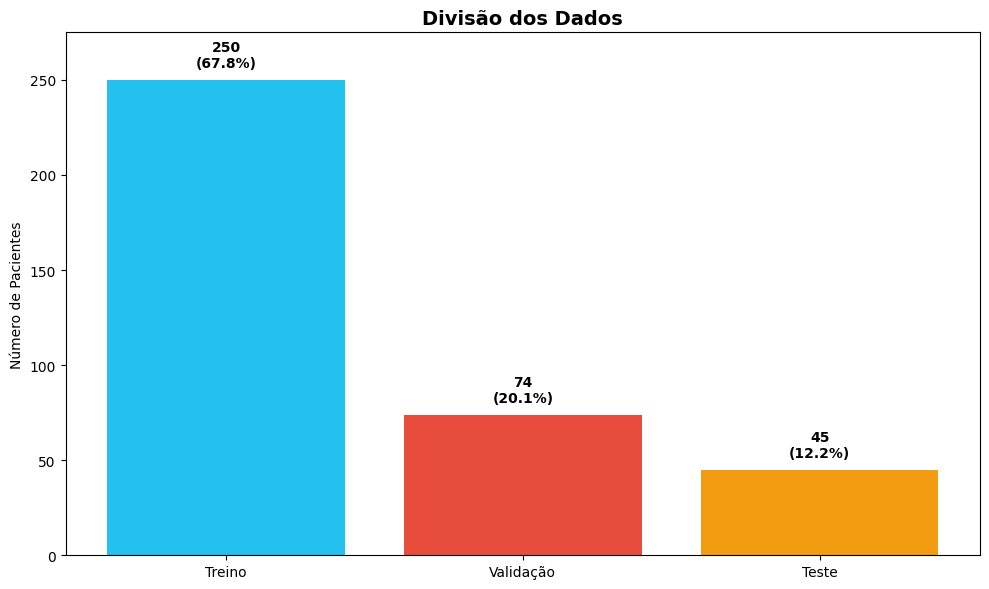

In [6]:
# Dados para visualização
division_data = [
    ('Treino', len(train_patients)),
    ('Validação', len(val_patients)),
    ('Teste', len(test_patients))
]

# Ordenar por quantidade
division_data.sort(key=lambda x: x[1], reverse=True)
labels = [item[0] for item in division_data]
counts = [item[1] for item in division_data]
percentages = [count/sum(counts)*100 for count in counts]

# Criar gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de barras
colors = ["#23c2ee", '#e74c3c', '#f39c12']
bars = ax.bar(labels, counts, color=colors)
ax.set_title('Divisão dos Dados', fontsize=14, fontweight='bold')
ax.set_ylabel('Número de Pacientes')

# Adicionar valores nas barras
for i, (count, percentage) in enumerate(zip(counts, percentages)):
    ax.text(i, count + 5, f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# Adicionar grid para melhor visualização
ax.grid(True, alpha=0.3)
ax.set_ylim(0, max(counts) * 1.1)

plt.grid(False)
plt.tight_layout()
plt.show()


<a id="analise-exploratoria"></a>

## 3. Análise Exploratória e Seleção de Modalidades

Antes do pré-processamento, é crucial entender as características das imagens de ressonância magnética.

In [7]:
## Implementação das Funções de Pré-processamento
# - apply_minmax_scaler: Normaliza intensidades de voxel para escala [0, 1]
# - remap_labels: Reatribui rótulos da máscara para sequência contínua (0,1,2,4 → 0,1,2,3)
# - combine_modalities: Combina modalidades selecionadas em volume multicanal normalizado

def apply_minmax_scaler(image_data):
    """Aplica Min-Max scaling em uma imagem 3D"""
    original_shape = image_data.shape
    image_flat = image_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    image_scaled = scaler.fit_transform(image_flat)
    return image_scaled.reshape(original_shape)

def remap_labels(mask_data):
    """Reatribui rótulos para serem contínuos: 0,1,2,4 -> 0,1,2,3"""
    mask_remapped = mask_data.copy()
    mask_remapped[mask_data == 4] = 3
    return mask_remapped

def combine_modalities(patient_files, selected_modalities=None):
    """Combina modalidades selecionadas em um volume multicanal"""
    if selected_modalities is None:
        selected_modalities = ['t1', 't1ce', 't2']  # Default: 3 modalidades

    combined_channels = []

    for modality in selected_modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            data_normalized = apply_minmax_scaler(data)
            combined_channels.append(data_normalized)

    if combined_channels:
        combined_volume = np.stack(combined_channels, axis=-1)
        return combined_volume
    return None


In [8]:
## Implementação das Funções de Análise de Modalidades Brutas
# - analyze_raw_modalities: Carrega e analisa dados das modalidades sem normalização
# - visualize_raw_modalities: Visualiza modalidades brutas com overlay de máscara
# - analyze_mask_labels: Analisa distribuição dos rótulos da máscara original

def analyze_raw_modalities(patient_files):
    """Analisa modalidades brutas antes da normalização"""
    modalities = ['t1', 't1ce', 't2', 'flair']
    raw_data = {}

    for modality in modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            raw_data[modality] = data

            # Análise básica
            brain_mask = data > 0  # Máscara simples para região do cérebro
            brain_voxels = data[brain_mask]
            background_percentage = (np.sum(data == 0) / data.size) * 100

            print(f"\n{modality.upper()}:")
            print(f"   Shape: {data.shape}")
            print(f"   Min: {data.min():.2f}, Max: {data.max():.2f}, Mean: {data.mean():.2f}")
            if len(brain_voxels) > 0:
                print(f"   Brain Mean: {brain_voxels.mean():.2f}")
            print(f"   Background: {background_percentage:.1f}%")

def visualize_raw_modalities(patient_files, mask_data=None, slice_idx=None):
    """Visualiza modalidades brutas com máscara opcional"""
    # Carregar dados das modalidades
    modalities = ['t1', 't1ce', 't2', 'flair']
    raw_data = {}

    for modality in modalities:
        if modality in patient_files:
            raw_data[modality] = nib.load(patient_files[modality]).get_fdata()

    if not raw_data:
        print(" Nenhuma modalidade encontrada")
        return

    # Se máscara não foi fornecida, tentar carregar
    if mask_data is None and 'seg' in patient_files:
        mask_data = nib.load(patient_files['seg']).get_fdata()

    # Usar as modalidades DISPONÍVEIS
    modalities_available = list(raw_data.keys())
    n_modalities = len(modalities_available)

    # Usar modalidades disponíveis para obter shape
    if slice_idx is None:
        slice_idx = raw_data[modalities_available[0]].shape[2] // 2

    fig, axes = plt.subplots(2, n_modalities, figsize=(20, 8))
    if n_modalities == 1:
        axes = axes.reshape(2, 1)

    # Primeira linha: modalidades brutas
    for i, modality in enumerate(modalities_available):
        data = raw_data[modality]
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Bruto')
        axes[0, i].axis('off')

    # Segunda linha: modalidades com overlay da máscara (se disponível)
    for i, modality in enumerate(modalities_available):
        data = raw_data[modality]
        axes[1, i].imshow(data[:, :, slice_idx], cmap='gray')

        if mask_data is not None:
            # Overlay da máscara
            mask_slice = mask_data[:, :, slice_idx]
            masked_overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
            axes[1, i].imshow(masked_overlay, cmap='viridis', alpha=0.3)
            axes[1, i].set_title(f'{modality.upper()} + Máscara')
        else:
            axes[1, i].set_title(f'{modality.upper()} - Sem Máscara')
        axes[1, i].axis('off')

    plt.suptitle(f'Modalidades Brutas - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

def analyze_mask_labels(mask_data):
    """Analisa os rótulos da máscara original"""
    unique_labels = np.unique(mask_data)

    print(f"\nANÁLISE DA MÁSCARA:")
    print(f"   Rótulos únicos: {unique_labels}")
    print(f"   Distribuição:")

    for label in unique_labels:
        count = np.sum(mask_data == label)
        percentage = (count / mask_data.size) * 100

        label_name = {
            0: "Fundo",
            1: "NCR/NET (Necrose)",
            2: "Edema",
            4: "Tumor Realçante"
        }.get(label, f"Desconhecido ({label})")

        print(f"     {label}: {label_name} - {count:,} voxels ({percentage:.2f}%)")

    return unique_labels

In [9]:
# Implementação das funções para análise de contraste e seleção de modalidades:
# - analyze_contrast_tumor_separation(): Calcula métricas de contraste entre regiões tumorais e fundo
# - select_best_modalities(): Seleciona as melhores modalidades baseada em scores de contraste
# - visualize_contrast_comparison(): Visualiza comparação de contraste entre modalidades


def analyze_contrast_tumor_separation(patient_files):
    """
    Analisa o contraste entre diferentes modalidades de MRI para separação de regiões tumorais.

    Calcula métricas de contraste entre diferentes regiões (fundo, tumor core, edema, realçante)
    para cada modalidade disponível. O contraste é calculado como a diferença normalizada
    entre as intensidades médias das regiões.

    Args:
        patient_files (dict): Dicionário contendo caminhos dos arquivos por modalidade
                             Deve incluir 'seg' para máscara e modalidades como 't1', 't1ce', etc.

    Returns:
        dict: Scores de contraste por modalidade contendo:
              - overall: Score geral de contraste
              - tumor_bg: Contraste tumor-fundo
              - enhancing_bg: Contraste realçante-fundo
              - edema_bg: Contraste edema-fundo
              - means: Médias por região
    """
    modalities = ['t1', 't1ce', 't2', 'flair']
    contrast_scores = {}

    # Carregar máscara primeiro
    if 'seg' not in patient_files:
        print("Máscara não disponível para análise de contraste")
        return {}

    mask_data = nib.load(patient_files['seg']).get_fdata()

    print(f"\nANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:")
    print("=" * 50)

    for modality in modalities:
        if modality not in patient_files:
            print(f"Modalidade {modality.upper()} não encontrada")
            continue

        # Carregar dados da modalidade
        data = nib.load(patient_files[modality]).get_fdata()

        # Extrair intensidades para diferentes regiões
        background = data[mask_data == 0]  # Fundo
        tumor_core = data[mask_data == 1]  # NCR/NET
        edema = data[mask_data == 2]       # Edema
        enhancing = data[mask_data == 4]   # Tumor realçante

        # Calcular médias das regiões (com verificação de existência)
        bg_mean = background.mean() if len(background) > 0 else 0
        tumor_mean = tumor_core.mean() if len(tumor_core) > 0 else 0
        edema_mean = edema.mean() if len(edema) > 0 else 0
        enh_mean = enhancing.mean() if len(enhancing) > 0 else 0

        # Calcular contrastes (diferenças normalizadas)
        contrast_tumor_bg = abs(tumor_mean - bg_mean) / (tumor_mean + bg_mean + 1e-8)
        contrast_enh_bg = abs(enh_mean - bg_mean) / (enh_mean + bg_mean + 1e-8)
        contrast_edema_bg = abs(edema_mean - bg_mean) / (edema_mean + bg_mean + 1e-8)

        # Score geral (média ponderada dos contrastes)
        overall_contrast = (contrast_tumor_bg + contrast_enh_bg + contrast_edema_bg) / 3

        contrast_scores[modality] = {
            'overall': overall_contrast,
            'tumor_bg': contrast_tumor_bg,
            'enhancing_bg': contrast_enh_bg,
            'edema_bg': contrast_edema_bg,
            'means': {
                'background': bg_mean,
                'tumor_core': tumor_mean,
                'edema': edema_mean,
                'enhancing': enh_mean
            }
        }

        print(f"\n{modality.upper()}:")
        print(f"   Médias por região:")
        print(f"     Fundo: {bg_mean:.2f}")
        print(f"     Tumor Core: {tumor_mean:.2f}")
        print(f"     Edema: {edema_mean:.2f}")
        print(f"     Realçante: {enh_mean:.2f}")
        print(f"   Contrastes:")
        print(f"     Tumor-Fundo: {contrast_tumor_bg:.3f}")
        print(f"     Realçante-Fundo: {contrast_enh_bg:.3f}")
        print(f"     Edema-Fundo: {contrast_edema_bg:.3f}")
        print(f"   Score Geral: {overall_contrast:.3f}")

    return contrast_scores

def select_best_modalities(contrast_scores, n_best=3):
    """
    Seleciona as melhores modalidades baseado nos scores de contraste.

    Args:
        contrast_scores (dict): Scores de contraste por modalidade
        n_best (int): Número de modalidades a selecionar

    Returns:
        list: Lista das melhores modalidades ordenadas por score
    """
    # Ordenar por score geral em ordem decrescente
    sorted_modalities = sorted(contrast_scores.items(),
                              key=lambda x: x[1]['overall'],
                              reverse=True)

    best_modalities = [mod[0] for mod in sorted_modalities[:n_best]]

    print(f"\nRANKING DE MODALIDADES (por contraste):")
    print("=" * 40)
    for i, (modality, scores) in enumerate(sorted_modalities, 1):
        status = "SELECIONADA" if modality in best_modalities else "Não selecionada"
        print(f"{i}. {modality.upper()}: {scores['overall']:.3f} - {status}")

    print(f"\nMODALIDADES SELECIONADAS: {[mod.upper() for mod in best_modalities]}")
    return best_modalities

def visualize_contrast_comparison(patient_files, slice_idx=None):
    """
    Visualiza comparação de contraste entre modalidades em uma fatia específica.

    Exibe as modalidades disponíveis em duas linhas: imagem original e com realce
    nas regiões tumorais para facilitar comparação visual do contraste.

    Args:
        patient_files (dict): Dicionário com caminhos dos arquivos por modalidade
        slice_idx (int, optional): Índice da fatia a visualizar. Se None, usa fatia central.
    """
    modalities = ['t1', 't1ce', 't2', 'flair']
    available_modalities = [mod for mod in modalities if mod in patient_files]

    if not available_modalities:
        print("Nenhuma modalidade encontrada")
        return

    # Carregar máscara
    if 'seg' not in patient_files:
        print("Máscara não disponível para visualização")
        mask_data = None
    else:
        mask_data = nib.load(patient_files['seg']).get_fdata()

    # Carregar primeira modalidade para obter slice central
    first_data = nib.load(patient_files[available_modalities[0]]).get_fdata()
    if slice_idx is None:
        slice_idx = first_data.shape[2] // 2

    fig, axes = plt.subplots(2, len(available_modalities), figsize=(20, 8))
    if len(available_modalities) == 1:
        axes = axes.reshape(2, 1)

    for i, modality in enumerate(available_modalities):
        # Carregar dados da modalidade
        data = nib.load(patient_files[modality]).get_fdata()

        # Imagem original
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Original')
        axes[0, i].axis('off')

        # Imagem com realce nas regiões de tumor
        if mask_data is not None:
            tumor_regions = (mask_data[:, :, slice_idx] > 0)
            enhanced_data = data[:, :, slice_idx].copy()
            enhanced_data[tumor_regions] = enhanced_data[tumor_regions] * 1.5  # Realçar tumor

            axes[1, i].imshow(enhanced_data, cmap='hot')
            axes[1, i].set_title(f'{modality.upper()} - Tumor Realçado')
        else:
            axes[1, i].imshow(data[:, :, slice_idx], cmap='gray')
            axes[1, i].set_title(f'{modality.upper()} - Sem Máscara')

        axes[1, i].axis('off')

    plt.suptitle(f'Comparação de Contraste - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

### 3.1. Visualização das Modalidades

Analisamos as quatro modalidades de MRI disponíveis (T1, T1ce, T2, FLAIR) para um paciente exemplo, observando a distribuição de intensidade dos voxels e a aparência do tumor em cada uma.

* **Análise da Máscara:** Verificamos os rótulos de segmentação para entender as classes que o modelo deve aprender.


In [10]:
first_patient = train_patients[0]  # Primeiro paciente do conjunto de TREINO
patient_files = train_patients_data[first_patient]

In [11]:
print(f"{first_patient}")

BraTS20_Training_252



ANÁLISE DA MÁSCARA:
   Rótulos únicos: [0. 1. 2. 4.]
   Distribuição:
     0.0: Fundo - 8,723,758 voxels (97.71%)
     1.0: NCR/NET (Necrose) - 28,927 voxels (0.32%)
     2.0: Edema - 130,784 voxels (1.46%)
     4.0: Tumor Realçante - 44,531 voxels (0.50%)


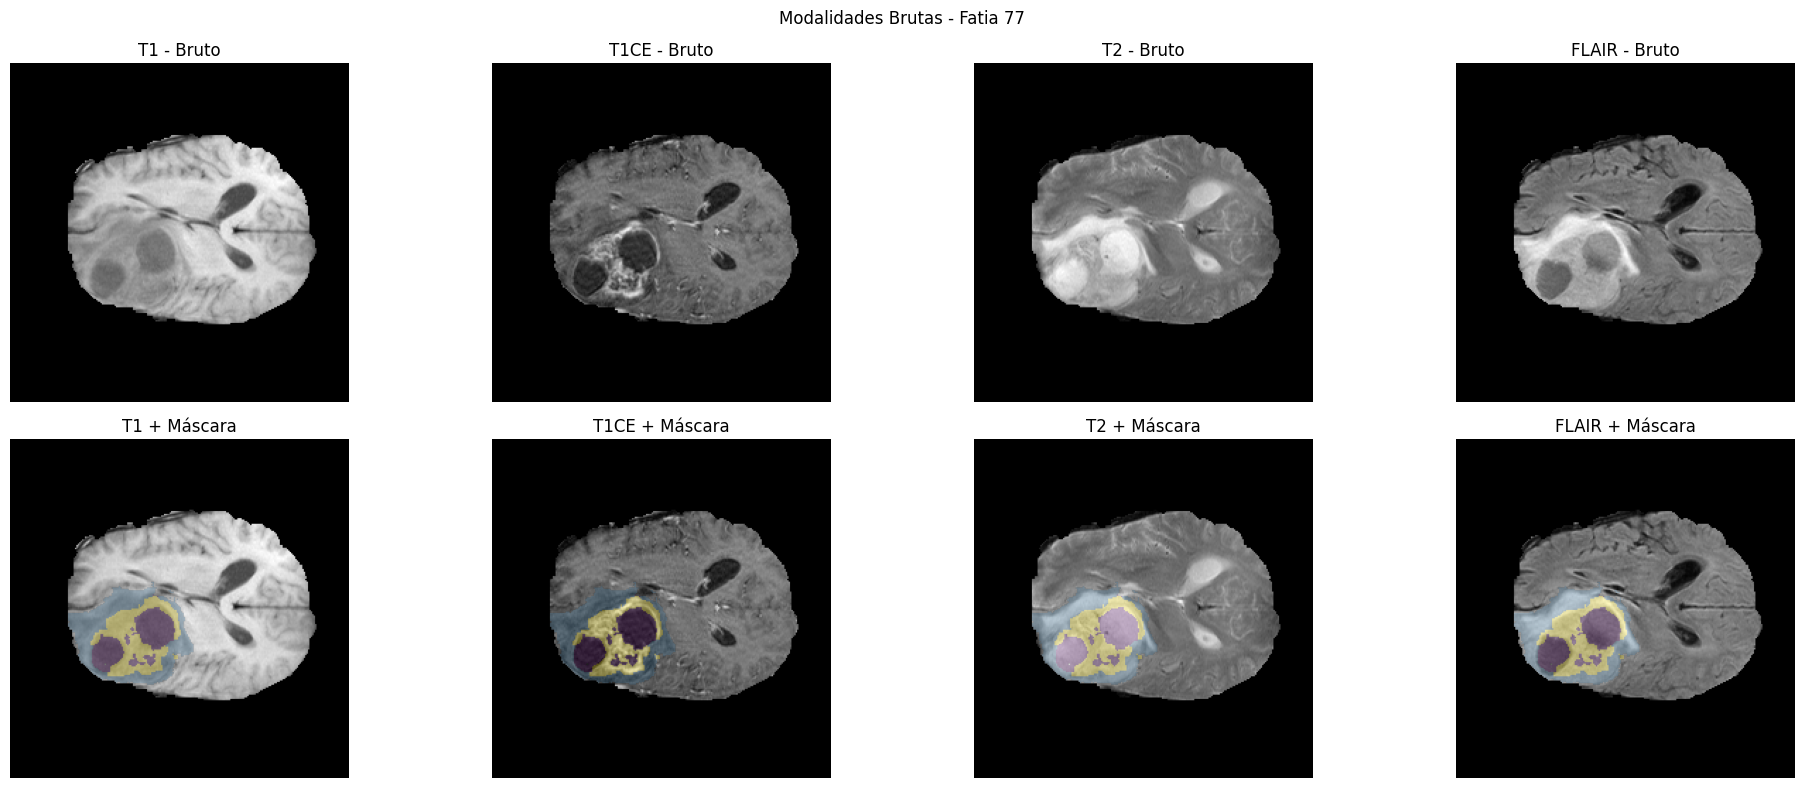

In [12]:
# Carregar e analisar máscara
if 'seg' in patient_files:
    mask_data = nib.load(patient_files['seg']).get_fdata()
    unique_labels = analyze_mask_labels(mask_data)

    # Visualizar modalidades brutas com máscara
    visualize_raw_modalities(patient_files, mask_data)

else:
    print("Máscara não disponível para análise")
    mask_data = None


In [13]:
print(f"ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: {first_patient}")

# Analisar modalidades brutas
analyze_raw_modalities(patient_files)

ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: BraTS20_Training_252

T1:
   Shape: (240, 240, 155)
   Min: 0.00, Max: 1390.00, Mean: 76.38
   Brain Mean: 415.92
   Background: 81.6%

T1CE:
   Shape: (240, 240, 155)
   Min: 0.00, Max: 519.00, Mean: 23.20
   Brain Mean: 126.31
   Background: 81.6%

T2:
   Shape: (240, 240, 155)
   Min: 0.00, Max: 1082.00, Mean: 85.75
   Brain Mean: 468.57
   Background: 81.7%

FLAIR:
   Shape: (240, 240, 155)
   Min: 0.00, Max: 1063.00, Mean: 78.08
   Brain Mean: 425.17
   Background: 81.6%


### 3.2. Seleção Automática de Modalidades por Contraste

Para otimizar o treinamento, implementamos uma análise quantitativa de contraste. As 3 modalidades que melhor separam as regiões tumorais do tecido saudável são selecionadas automaticamente para compor o volume de entrada do modelo.

In [14]:
# Análise de contraste das modalidades para seleção automática
contrast_scores = analyze_contrast_tumor_separation(patient_files)



ANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:

T1:
   Médias por região:
     Fundo: 69.50
     Tumor Core: 312.89
     Edema: 385.35
     Realçante: 362.32
   Contrastes:
     Tumor-Fundo: 0.636
     Realçante-Fundo: 0.678
     Edema-Fundo: 0.694
   Score Geral: 0.670

T1CE:
   Médias por região:
     Fundo: 20.94
     Tumor Core: 79.96
     Edema: 109.98
     Realçante: 173.16
   Contrastes:
     Tumor-Fundo: 0.585
     Realçante-Fundo: 0.784
     Edema-Fundo: 0.680
   Score Geral: 0.683

T2:
   Médias por região:
     Fundo: 71.74
     Tumor Core: 778.78
     Edema: 663.89
     Realçante: 682.33
   Contrastes:
     Tumor-Fundo: 0.831
     Realçante-Fundo: 0.810
     Edema-Fundo: 0.805
   Score Geral: 0.815

FLAIR:
   Médias por região:
     Fundo: 65.04
     Tumor Core: 518.61
     Edema: 670.70
     Realçante: 605.11
   Contrastes:
     Tumor-Fundo: 0.777
     Realçante-Fundo: 0.806
     Edema-Fundo: 0.823
   Score Geral: 0.802



SELEÇÃO AUTOMÁTICA DAS MELHORES MODALIDADES:
Critério: Maior capacidade de separação entre regiões tumorais e tecido saudável

RANKING DE MODALIDADES (por contraste):
1. T2: 0.815 - SELECIONADA
2. FLAIR: 0.802 - SELECIONADA
3. T1CE: 0.683 - SELECIONADA
4. T1: 0.670 - Não selecionada

MODALIDADES SELECIONADAS: ['T2', 'FLAIR', 'T1CE']

COMPARAÇÃO VISUAL DE CONTRASTE:
Objetivo: Confirmar visualmente a qualidade das modalidades selecionadas


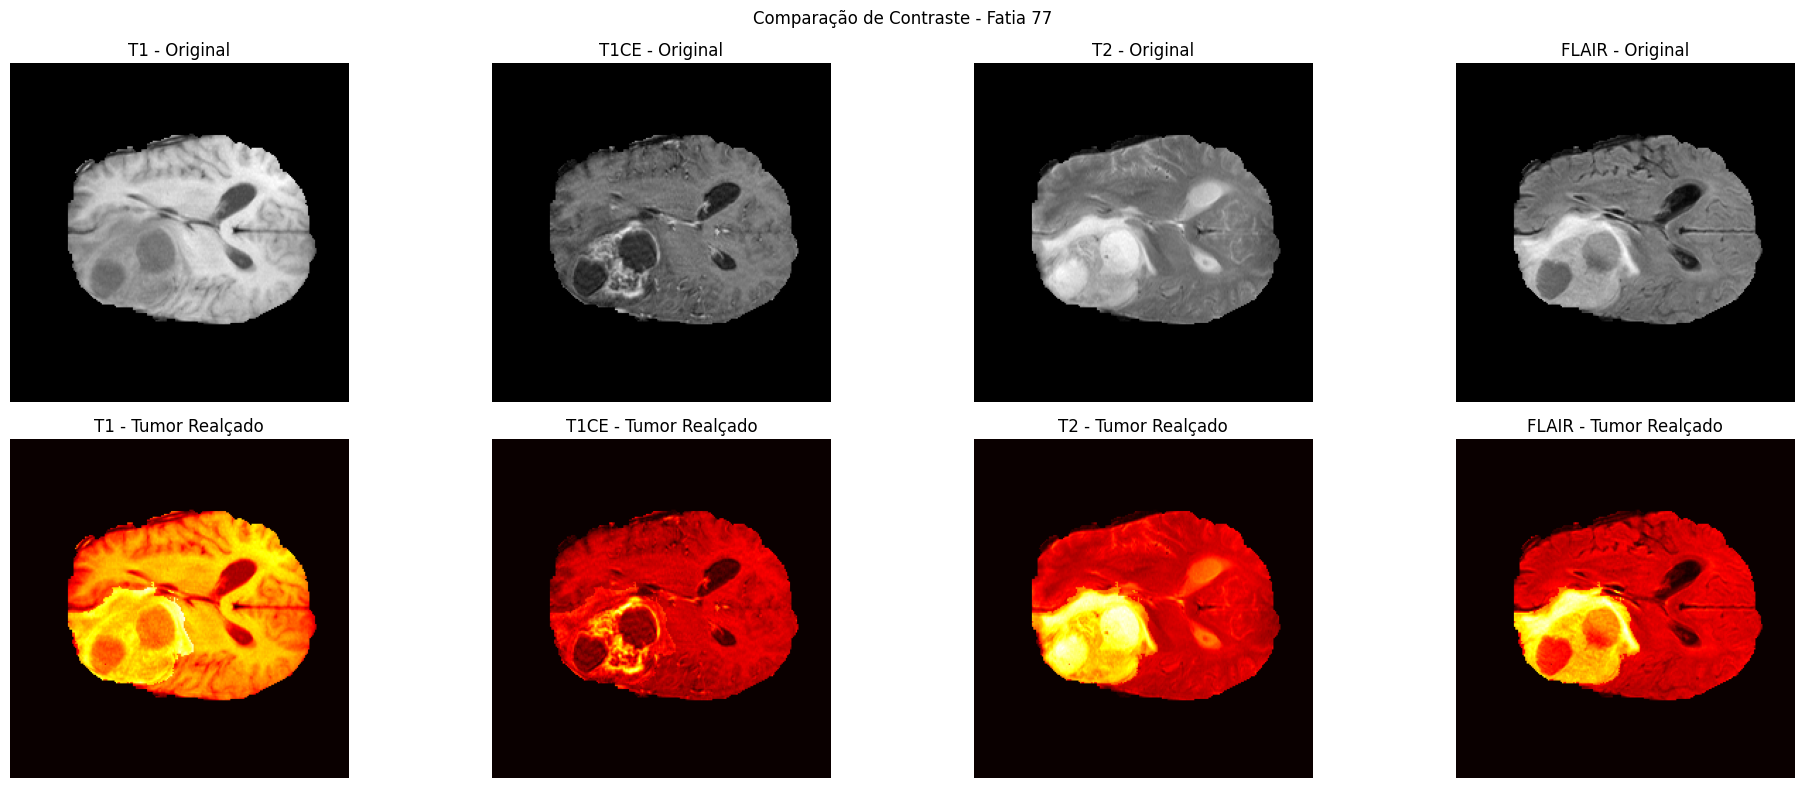

In [15]:
#  Seleção automática das 3 melhores modalidades baseada em scores de contraste
print("\nSELEÇÃO AUTOMÁTICA DAS MELHORES MODALIDADES:")
print("Critério: Maior capacidade de separação entre regiões tumorais e tecido saudável")
best_modalities = select_best_modalities(contrast_scores, n_best=3)

# Visualização comparativa das modalidades para validação visual
print("\nCOMPARAÇÃO VISUAL DE CONTRASTE:")
print("Objetivo: Confirmar visualmente a qualidade das modalidades selecionadas")
visualize_contrast_comparison(patient_files)

<a id="preprocessamento"></a>

## 4. Pipeline de Pré-processamento

Com as modalidades selecionadas, aplicamos uma sequência de transformações para preparar os dados para o treinamento da rede neural.

**Etapas do Pipeline:**
1.  **Normalização Min-Max:** As intensidades de voxel de cada modalidade são normalizadas para a escala [0, 1].
2.  **Remapeamento da Máscara:** Os rótulos da máscara (0, 1, 2, 4) são remapeados para uma sequência contínua (0, 1, 2, 3) para compatibilidade com a função de perda.
3.  **Combinação de Modalidades:** As modalidades selecionadas são empilhadas para criar um volume 3D multicanal.
4.  **Redimensionamento Proporcional:** Os volumes são redimensionados para um tamanho fixo de `(128, 128, 64)`, preservando as proporções espaciais.

In [16]:
def resize_volume_proportional(volume, mask, target_size=(128, 128, 64)):
    """
    Redimensiona volume preservando proporções para dimensões específicas

    Args:
        volume: Volume de entrada (H, W, D, C)
        mask: Máscara correspondente (H, W, D)
        target_size: Tamanho desejado (altura, largura, profundidade)

    Returns:
        volume_resized, mask_resized: Volumes redimensionados
    """

    # Calcular fatores de zoom para cada dimensão
    original_h, original_w, original_d = volume.shape[:3]
    target_h, target_w, target_d = target_size

    zoom_h = target_h / original_h
    zoom_w = target_w / original_w
    zoom_d = target_d / original_d

    # Redimensionar volume
    if volume.ndim == 4: # (C, H, W, D)
        volume_resized = np.zeros((target_h, target_w, target_d, volume.shape[3]))

        for channel in range(volume.shape[3]):
            volume_resized[:, :, :, channel] = zoom(
                volume[:, :, :, channel],
                (zoom_h, zoom_w, zoom_d),
                order=1  # Interpolação linear
            )
    else:  # (H, W, D)
        volume_resized = zoom(
            volume,
            (zoom_h, zoom_w, zoom_d),
            order=1
        )

    # Redimensionar máscara com interpolação nearest neighbor
    if mask is not None:
        mask_resized = zoom(
            mask,
            (zoom_h, zoom_w, zoom_d),
            order=0  # Interpolação nearest neighbor para labels
        )
    else:
        mask_resized = None

    return volume_resized, mask_resized

def visualize_resize_process(volume, mask, target_size=(128, 128, 64)):
    """
    Visualiza o processo de redimensionamento preservando proporções
    """

    # Aplicar redimensionamento
    volume_resized, mask_resized = resize_volume_proportional(volume, mask, target_size)

    # Visualizar comparação
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Calcular slice central
    original_slice = volume.shape[2] // 2
    resized_slice = volume_resized.shape[2] // 2

    # Primeira linha - Original
    axes[0, 0].imshow(volume[:, :, original_slice, 0], cmap='gray')
    axes[0, 0].set_title(f'Original - Modalidade 1\n{volume.shape[:3]}')
    axes[0, 0].axis('off')

    if volume.shape[3] > 1:
        axes[0, 1].imshow(volume[:, :, original_slice, 1], cmap='gray')
        axes[0, 1].set_title(f'Original - Modalidade 2\n{volume.shape[:3]}')
        axes[0, 1].axis('off')
    else:
        axes[0, 1].axis('off')

    if mask is not None:
        axes[0, 2].imshow(mask[:, :, original_slice], cmap='viridis')
        axes[0, 2].set_title(f'Máscara Original\n{mask.shape}')
        axes[0, 2].axis('off')

    # Segunda linha - Redimensionado
    axes[1, 0].imshow(volume_resized[:, :, resized_slice, 0], cmap='gray')
    axes[1, 0].set_title(f'Redimensionado - Modalidade 1\n{volume_resized.shape[:3]}')
    axes[1, 0].axis('off')

    if volume_resized.shape[3] > 1:
        axes[1, 1].imshow(volume_resized[:, :, resized_slice, 1], cmap='gray')
        axes[1, 1].set_title(f'Redimensionado - Modalidade 2\n{volume_resized.shape[:3]}')
        axes[1, 1].axis('off')
    else:
        axes[1, 1].axis('off')

    if mask_resized is not None:
        axes[1, 2].imshow(mask_resized[:, :, resized_slice], cmap='viridis')
        axes[1, 2].set_title(f'Máscara Redimensionada\n{mask_resized.shape}')
        axes[1, 2].axis('off')

    plt.suptitle('Comparação: Original vs Redimensionado (Proporções Preservadas)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return volume_resized, mask_resized

def analyze_resize_quality(volume_original, volume_resized, mask_original=None, mask_resized=None):
    """
    Analisa a qualidade do redimensionamento - versão simplificada
    """

    # Análise da preservação de intensidades
    for channel in range(volume_original.shape[3]):
        orig_channel = volume_original[:, :, :, channel]
        resized_channel = volume_resized[:, :, :, channel]

        orig_mean = orig_channel.mean()
        resized_mean = resized_channel.mean()
        diff_percent = abs(orig_mean - resized_mean) / orig_mean * 100

        print(f"Modalidade {channel + 1}:")
        print(f"  Original - Min: {orig_channel.min():.3f}, Max: {orig_channel.max():.3f}, Mean: {orig_mean:.3f}")
        print(f"  Redimensionado - Min: {resized_channel.min():.3f}, Max: {resized_channel.max():.3f}, Mean: {resized_mean:.3f}")
        print(f"  Diferença relativa: {diff_percent:.2f}%")

    # Estatísticas de redimensionamento
    original_volume = np.prod(volume_original.shape[:3])
    resized_volume = np.prod(volume_resized.shape[:3])
    reduction = (1 - (resized_volume / original_volume)) * 100
    compression = original_volume / resized_volume

    print(f"\nRedução de volume: {reduction:.1f}%")
    print(f"Fator de compressão: {compression:.2f}x")


TESTE DO PIPELINE COM REDIMENSIONAMENTO PROPORCIONAL
Paciente: BraTS20_Training_252
Modalidades: ['T2', 'FLAIR', 'T1CE']
--------------------------------------------------
Volume original: (240, 240, 155, 3)
Aplicando redimensionamento proporcional para (128, 128, 64)...


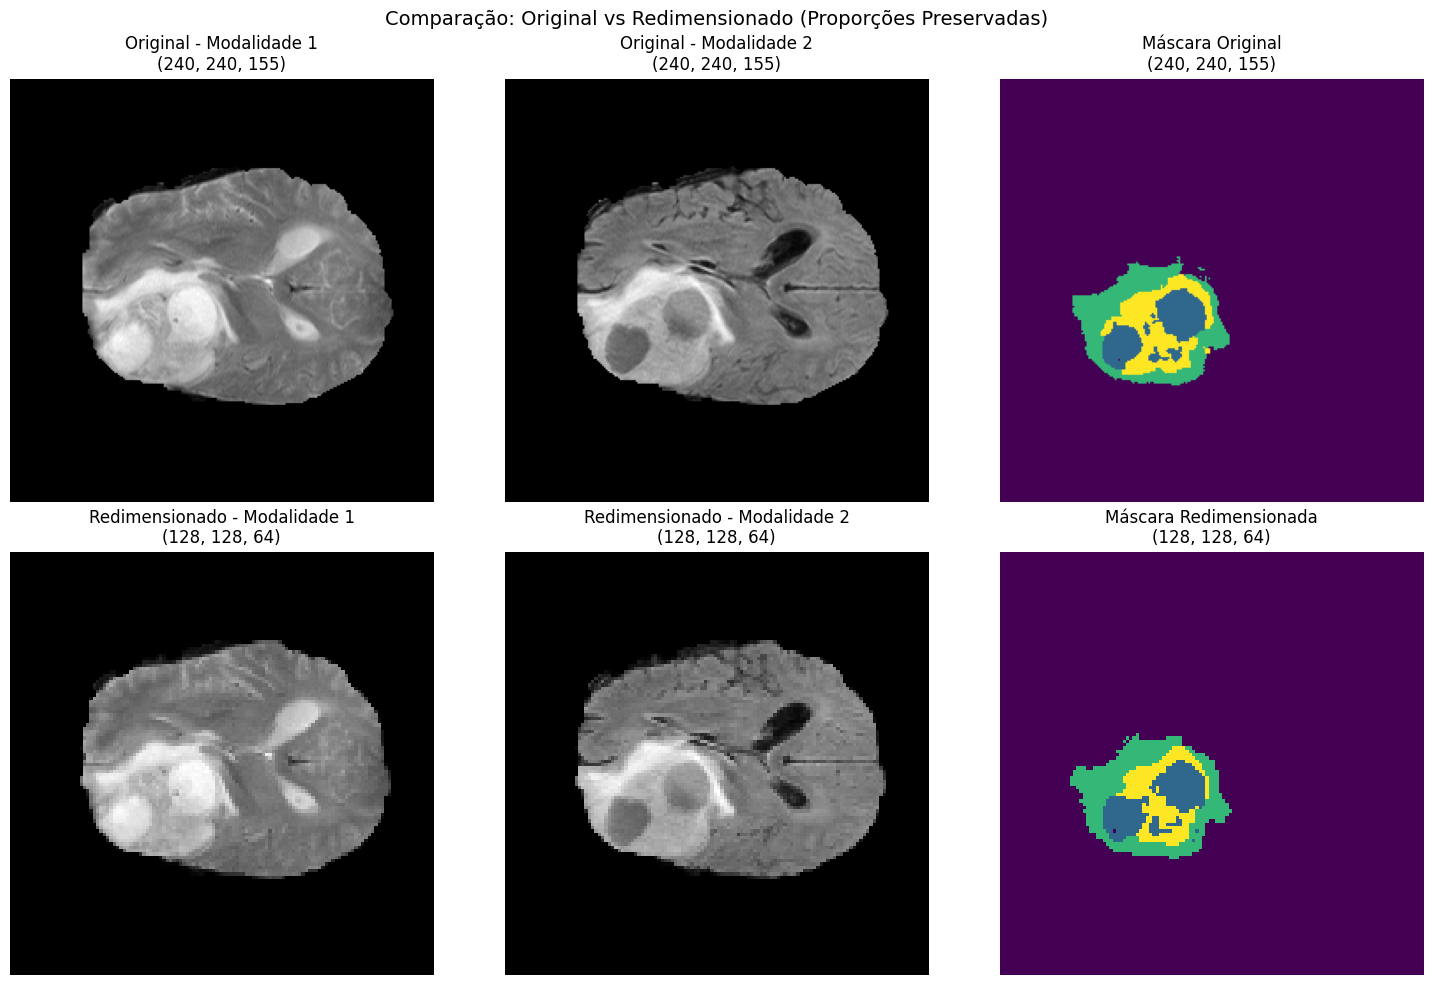

In [17]:
# Teste do Pipeline com Modalidades Selecionadas e Redimensionamento
print("TESTE DO PIPELINE COM REDIMENSIONAMENTO PROPORCIONAL")
print(f"Paciente: {first_patient}")
print(f"Modalidades: {[mod.upper() for mod in best_modalities]}")
print("-" * 50)

# Processar dados com modalidades selecionadas
combined_volume = combine_modalities(patient_files, best_modalities)
mask = None
if 'seg' in patient_files:
    mask = nib.load(patient_files['seg']).get_fdata()
    mask = remap_labels(mask)

# Aplicar redimensionamento proporcional
if combined_volume is not None:
    print(f"Volume original: {combined_volume.shape}")
    print(f"Aplicando redimensionamento proporcional para {TARGET_SIZE}...")

    # Redimensionamento com análise visual
    volume_final, mask_final = visualize_resize_process(combined_volume, mask, TARGET_SIZE)

else:
    print("Erro: Volume combinado não pôde ser criado")

In [18]:
analyze_resize_quality(combined_volume, volume_final, mask, mask_final)

Modalidade 1:
  Original - Min: 0.000, Max: 1.000, Mean: 0.079
  Redimensionado - Min: 0.000, Max: 0.894, Mean: 0.078
  Diferença relativa: 1.58%
Modalidade 2:
  Original - Min: 0.000, Max: 1.000, Mean: 0.073
  Redimensionado - Min: 0.000, Max: 0.870, Mean: 0.072
  Diferença relativa: 1.56%
Modalidade 3:
  Original - Min: 0.000, Max: 1.000, Mean: 0.045
  Redimensionado - Min: 0.000, Max: 0.782, Mean: 0.044
  Diferença relativa: 1.58%

Redução de volume: 88.3%
Fator de compressão: 8.51x


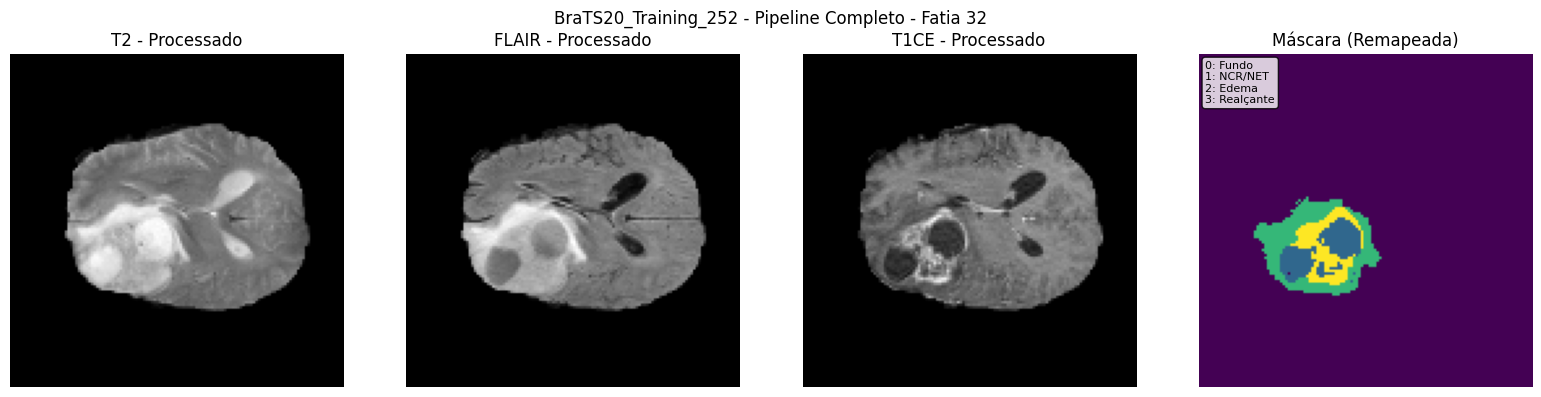


ESTATÍSTICAS FINAIS:
Volume processado: (128, 128, 64, 3)
Modalidades utilizadas: ['T2', 'FLAIR', 'T1CE']
Range de valores por modalidade:
  T2: [0.000, 0.894]
  FLAIR: [0.000, 0.870]
  T1CE: [0.000, 0.782]
Máscara: (128, 128, 64)
Distribuição de rótulos:
  0 (Fundo): 1,024,975 voxels (97.75%)
  1 (NCR/NET): 3,264 voxels (0.31%)
  2 (Edema): 15,153 voxels (1.45%)
  3 (Realçante): 5,184 voxels (0.49%)


In [19]:
# Visualização do Resultado Final
if 'volume_final' in locals() and volume_final is not None:
    slice_idx = volume_final.shape[2] // 2

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Mostrar as 3 modalidades selecionadas
    selected_names = [mod.upper() for mod in best_modalities]

    for i in range(min(3, volume_final.shape[3])):
        axes[i].imshow(volume_final[:, :, slice_idx, i], cmap='gray')
        axes[i].set_title(f'{selected_names[i]} - Processado')
        axes[i].axis('off')

    # Máscara na última posição
    if mask_final is not None:
        axes[3].imshow(mask_final[:, :, slice_idx], cmap='viridis')
        axes[3].set_title('Máscara (Remapeada)')
        axes[3].axis('off')

        # Mostrar legenda dos rótulos
        unique_labels = np.unique(mask_final)
        legend_text = []
        for label in unique_labels:
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            legend_text.append(f"{int(label)}: {label_name.get(label, 'Desconhecido')}")

        axes[3].text(0.02, 0.98, '\n'.join(legend_text),
                    transform=axes[3].transAxes, fontsize=8,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.suptitle(f'{first_patient} - Pipeline Completo - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

    # Estatísticas finais
    print("\nESTATÍSTICAS FINAIS:")
    print(f"Volume processado: {volume_final.shape}")
    print(f"Modalidades utilizadas: {selected_names}")
    print(f"Range de valores por modalidade:")
    for i, name in enumerate(selected_names):
        channel_data = volume_final[:, :, :, i]
        print(f"  {name}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")

    if mask_final is not None:
        print(f"Máscara: {mask_final.shape}")
        print(f"Distribuição de rótulos:")
        for label in np.unique(mask_final):
            count = np.sum(mask_final == label)
            percentage = (count / mask_final.size) * 100
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            print(f"  {int(label)} ({label_name.get(label, 'Desconhecido')}): {count:,} voxels ({percentage:.2f}%)")

else:
    print("Não foi possível visualizar - dados não disponíveis")

<a id="dataset-loader"></a>

## 5. Dataset e DataLoader PyTorch

**Implementação do Dataset Customizado**

Esta seção implementa:
- **Dataset customizado** para BraTS2020
- **DataLoader** para treinamento
- **Tensores PyTorch** preparados para a U-Net 3D

In [20]:
class BraTSDataset(Dataset):
    """Dataset para segmentação de tumores cerebrais BraTS"""

    def __init__(self, patient_ids, patients_data, selected_modalities=None, target_size=TARGET_SIZE):
        self.patient_ids = patient_ids
        self.patients_data = patients_data
        self.selected_modalities = selected_modalities or ['t2', 'flair', 't1ce']
        self.target_size = target_size

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        patient_files = self.patients_data[patient_id]

        try:
            # Combinar modalidades selecionadas
            combined_volume = combine_modalities(patient_files, self.selected_modalities)

            # Processar máscara se disponível
            mask = None
            if 'seg' in patient_files:
                mask = nib.load(patient_files['seg']).get_fdata()
                mask = remap_labels(mask)

            # Aplicar redimensionamento proporcional
            if combined_volume is not None:
                volume_final, mask_final = resize_volume_proportional(combined_volume, mask, self.target_size)

                # Converter para tensores PyTorch
                volume_tensor = torch.from_numpy(volume_final).permute(3, 0, 1, 2).float()

                if mask_final is not None:
                    mask_tensor = torch.from_numpy(mask_final).long()
                else:
                    # Máscara vazia se não disponível
                    mask_tensor = torch.zeros(self.target_size, dtype=torch.long)

                return {
                    'volume': volume_tensor,
                    'mask': mask_tensor,
                    'patient_id': patient_id
                }
            else:
                raise ValueError(f"Não foi possível processar {patient_id}")

        except Exception as e:
            print(f"Erro ao processar {patient_id}: {e}")
            # Retornar tensores vazios em caso de erro
            return {
                'volume': torch.zeros((len(self.selected_modalities), *self.target_size)),
                'mask': torch.zeros(self.target_size, dtype=torch.long),
                'patient_id': patient_id
            }

In [21]:
# Criar datasets com modalidades selecionadas
train_dataset = BraTSDataset(train_patients[:6], train_patients_data, best_modalities)
val_dataset = BraTSDataset(val_patients[:3], train_patients_data, best_modalities)

print("Dataset criado com modalidades selecionadas:")
print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
print(f"   Treino: {len(train_dataset)} pacientes")
print(f"   Validação: {len(val_dataset)} pacientes")

Dataset criado com modalidades selecionadas:
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Treino: 6 pacientes
   Validação: 3 pacientes


In [22]:
# Criação dos DataLoaders
batch_size = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # 0 para evitar problemas no Windows
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)
print("DataLoaders criados:")
print(f"   Treino: {len(train_loader)} batches de {batch_size}")
print(f"   Validação: {len(val_loader)} batches de {batch_size}")

# Testar um batch
try:
    batch = next(iter(train_loader))
    print(f"\nBatch de teste:")
    print(f"   Volume batch: {batch['volume'].shape}")  # (B, C, H, W, D)
    print(f"   Máscara batch: {batch['mask'].shape}")   # (B, H, W, D)
    print(f"   Pacientes: {batch['patient_id']}")
    print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
    print(f"   Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

    # Estatísticas do batch
    print(f"\nEstatísticas do batch:")
    for i, mod in enumerate(best_modalities):
        channel_data = batch['volume'][:, i]
        print(f"   {mod.upper()}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")

    unique_labels = torch.unique(batch['mask'])
    print(f"   Rótulos únicos: {unique_labels.tolist()}")

except Exception as e:
    print(f"Erro ao testar batch: {e}")

DataLoaders criados:
   Treino: 3 batches de 2
   Validação: 2 batches de 2

Batch de teste:
   Volume batch: torch.Size([2, 3, 128, 128, 64])
   Máscara batch: torch.Size([2, 128, 128, 64])
   Pacientes: ['BraTS20_Training_067', 'BraTS20_Training_070']
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Device: CUDA

Estatísticas do batch:
   T2: [0.000, 0.872]
   FLAIR: [0.000, 0.934]
   T1CE: [0.000, 0.951]
   Rótulos únicos: [0, 1, 2, 3]


<a id="modelo-perda-metricas"></a>

## 6. Modelo, Perda e Métricas
Nesta seção, definimos os três pilares do nosso processo de aprendizado: a arquitetura do modelo, a função de Loss e as métricas que usarão para avaliá-lo.

###  Modelo U-Net 3D

## Arquitetura de Segmentação

*Esta seção implementará o modelo U-Net 3D para segmentação de tumores cerebrais*

### Componentes Planejados:
- **Encoder**: Contractive path com convoluções 3D
- **Decoder**: Expansive path com skip connections
- **Loss Function**: Dice Loss + CrossEntropy
- **Métricas**: Dice Score, Sensitivity/Specificity

### Especificações Técnicas:
- **Input**: (B, 3, 128, 128, 64) - 3 modalidades selecionadas
- **Output**: (B, 4, 128, 128, 64) - 4 classes de segmentação
- **Ativação**: LeakyReLU para camadas internas, Softmax para saída

In [23]:
## Unet 3d com LeakyReLU
class DoubleConv3D(nn.Module):
    """(Conv3D -> GroupNorm -> LeakyReLU) * 2 - Otimi encoder/decoder"""
    def __init__(self, in_channels, out_channels, num_groups=8, is_encoder=True):
        super().__init__()

        # Escolher ativação baseada na posição (encoder vs decoder)
        if is_encoder:
            activation = nn.LeakyReLU(0.01, inplace=True)
        else:
            activation = nn.LeakyReLU(0.2, inplace=True)

        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            activation,

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            activation
        )

    def forward(self, x):
        return self.double_conv(x)

class Down3D(nn.Module):
    """Downscaling com MaxPool3D e DoubleConv3D - Encoder"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv3D(in_channels, out_channels, is_encoder=True)  # Encoder usa LeakyReLU(0.01)
        )

    def forward(self, x):
        return self.encoder(x)


class Up3D(nn.Module):
    """Upscaling com ConvTranspose3D e DoubleConv3D - Decoder"""
    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()

        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
            self.conv = DoubleConv3D(in_channels, out_channels, is_encoder=False)  # Decoder usa LeakyReLU(0.2)
        else:
            self.up = nn.ConvTranspose3d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv3D(in_channels, out_channels, is_encoder=False)


    def forward(self, x1, x2):
        x1 = self.up(x1)

        # Ajuste de dimensões para concatenação
        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                       diffY // 2, diffY - diffY // 2,
                       diffZ // 2, diffZ - diffZ // 2])

        # Concatenar ao longo da dimensão de canais
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv3D(nn.Module):
    """Camada de saída com Conv3D 1x1x1"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    """U-Net 3D para segmentação de tumores cerebrais"""
    def __init__(self, in_channels=3, n_classes=4, n_channels=24):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        # Encoder - usa LeakyReLU(0.01)
        self.input_conv = DoubleConv3D(in_channels, n_channels, is_encoder=True)
        self.down1 = Down3D(n_channels, 2 * n_channels)
        self.down2 = Down3D(2 * n_channels, 4 * n_channels)
        self.down3 = Down3D(4 * n_channels, 8 * n_channels)

        # Bottleneck com Dropout
        self.down4 = Down3D(8 * n_channels, 8 * n_channels)

        # Decoder - usa LeakyReLU(0.2)
        self.up1 = Up3D(16 * n_channels, 4 * n_channels)
        self.up2 = Up3D(8 * n_channels, 2 * n_channels)
        self.up3 = Up3D(4 * n_channels, n_channels)
        self.up4 = Up3D(2 * n_channels, n_channels)

        # saída
        self.output_conv = OutConv3D(n_channels, n_classes)


    def forward(self, x):
        # Encoder
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        # Bottleneck
        x5 = self.down4(x4)

        # Decoder com skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Saída
        logits = self.output_conv(x)
        return logits


In [24]:
model = UNet3D(in_channels=3, n_classes=4, n_channels=24)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Devide: {device}")

Devide: cuda


In [25]:
def print_detailed_architecture(model, input_shape=(1, 3, 128, 128, 64)):
    """
    Imprime apenas o detalhamento da arquitetura da U-Net 3D
    """

    total_params = sum(p.numel() for p in model.parameters())


    print("🔍 DETALHAMENTO DA ARQUITETURA U-NET 3D")
    print("=" * 60)
    print(f" Parâmetros Totais: {total_params:,}")

    # Simular passagem para obter dimensões
    with torch.no_grad():
        x = torch.randn(input_shape).to(next(model.parameters()).device)

        print(f"  ENTRADA: {list(x.shape)}")

        # ENCODER
        print(f"\n ENCODER (Contractive Path):")
        print(f"   ├── Input Conv (3→{model.n_channels})")
        x1 = model.input_conv(x)
        print(f"   │   └── Saída: {list(x1.shape)} - {x1.numel():,} elementos")

        print(f"   ├── Down1 ({model.n_channels}→{2*model.n_channels})")
        x2 = model.down1(x1)
        print(f"   │   └── Saída: {list(x2.shape)} - {x2.numel():,} elementos")

        print(f"   ├── Down2 ({2*model.n_channels}→{4*model.n_channels})")
        x3 = model.down2(x2)
        print(f"   │   └── Saída: {list(x3.shape)} - {x3.numel():,} elementos")

        print(f"   ├── Down3 ({4*model.n_channels}→{8*model.n_channels})")
        x4 = model.down3(x3)
        print(f"   │   └── Saída: {list(x4.shape)} - {x4.numel():,} elementos")

        print(f"   └── Down4 ({8*model.n_channels}→{8*model.n_channels}) - BOTTLENECK")
        x5 = model.down4(x4)
        print(f"       └── Saída: {list(x5.shape)} - {x5.numel():,} elementos")

        # DECODER
        print(f"\n DECODER (Expansive Path com Skip Connections):")
        print(f"   ├── Up1 ({16*model.n_channels}→{4*model.n_channels}) + Skip from Down3")
        x = model.up1(x5, x4)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")

        print(f"   ├── Up2 ({8*model.n_channels}→{2*model.n_channels}) + Skip from Down2")
        x = model.up2(x, x3)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")

        print(f"   ├── Up3 ({4*model.n_channels}→{model.n_channels}) + Skip from Down1")
        x = model.up3(x, x2)
        print(f"   │   └── Saída: {list(x.shape)} - {x.numel():,} elementos")

        print(f"   └── Up4 ({2*model.n_channels}→{model.n_channels}) + Skip from Input")
        x = model.up4(x, x1)
        print(f"       └── Saída: {list(x.shape)} - {x.numel():,} elementos")

        # SAÍDA
        print(f"\n CAMADA DE SAÍDA:")
        print(f"   └── Output Conv ({model.n_channels}→{model.n_classes})")
        logits = model.output_conv(x)
        print(f"       └── Saída Final: {list(logits.shape)} - {logits.numel():,} elementos")


# Executar apenas o detalhamento da arquitetura
print_detailed_architecture(model)

🔍 DETALHAMENTO DA ARQUITETURA U-NET 3D
 Parâmetros Totais: 5,651,884
  ENTRADA: [1, 3, 128, 128, 64]

 ENCODER (Contractive Path):
   ├── Input Conv (3→24)
   │   └── Saída: [1, 24, 128, 128, 64] - 25,165,824 elementos
   ├── Down1 (24→48)
   │   └── Saída: [1, 48, 64, 64, 32] - 6,291,456 elementos
   ├── Down2 (48→96)
   │   └── Saída: [1, 96, 32, 32, 16] - 1,572,864 elementos
   ├── Down3 (96→192)
   │   └── Saída: [1, 192, 16, 16, 8] - 393,216 elementos
   └── Down4 (192→192) - BOTTLENECK
       └── Saída: [1, 192, 8, 8, 4] - 49,152 elementos

 DECODER (Expansive Path com Skip Connections):
   ├── Up1 (384→96) + Skip from Down3
   │   └── Saída: [1, 96, 16, 16, 8] - 196,608 elementos
   ├── Up2 (192→48) + Skip from Down2
   │   └── Saída: [1, 48, 32, 32, 16] - 786,432 elementos
   ├── Up3 (96→24) + Skip from Down1
   │   └── Saída: [1, 24, 64, 64, 32] - 3,145,728 elementos
   └── Up4 (48→24) + Skip from Input
       └── Saída: [1, 24, 128, 128, 64] - 25,165,824 elementos

 CAMADA DE

###  Loss

**Funções de Loss utilizadas:**
- **Dice Loss**: Otimizada para maximizar a sobreposição entre as regiões segmentadas e o ground truth.
- **Combined Loss**: Combinação ponderada entre Dice Loss e Cross-Entropy Loss, utilizada como função de perda principal no treinamento. A Cross-Entropy Loss não é usada isoladamente, apenas como parte da loss combinada.



In [26]:
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss

class DiceLoss(nn.Module):
    """Dice Loss para segmentação multi-classe"""
    def __init__(self, smooth=1e-6, reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, predictions, targets):
        """
        Args:
            predictions: (B, C, H, W, D) - logits do modelo
            targets: (B, H, W, D) - ground truth labels
        """
        # Aplicar softmax para obter probabilidades
        predictions = F.softmax(predictions, dim=1)

        # Converter targets para one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=predictions.shape[1])
        targets_one_hot = targets_one_hot.permute(0, 4, 1, 2, 3).float()

        # Calcular Dice Score para cada classe
        dice_scores = []
        for class_idx in range(predictions.shape[1]):
            pred_class = predictions[:, class_idx]
            target_class = targets_one_hot[:, class_idx]

            intersection = (pred_class * target_class).sum()
            union = pred_class.sum() + target_class.sum()

            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice_score)

        # Dice Loss = 1 - Dice Score
        dice_loss = 1 - torch.stack(dice_scores).mean()

        return dice_loss


class BCEDiceLoss_Multiclass(nn.Module):
    """
    Implementação da perda combinada de Cross-Entropy e Dice Loss para um problema
    de segmentação multi-classe.
    """
    def __init__(self, dice_weight=0.6, ce_weight=0.4, class_weights=None):
        super(BCEDiceLoss_Multiclass, self).__init__()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.smooth = 1e-6

        # CrossEntropyLoss é a versão multi-classe da BCE.
        # Os pesos ajudam a combater o desbalanceamento de classes.
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)

        self.class_weights = class_weights

    def forward(self, logits, targets):
        """
        Args:
            logits: (B, C, H, W, D) - Saída bruta do modelo (antes de softmax).
            targets: (B, H, W, D) - Máscaras de ground truth com labels (0, 1, 2, 3).
        """
        # --- Cross-Entropy Ponderada ---
        ce_loss = self.ce_loss(logits, targets)

        # --- Dice Loss Ponderada ---
        # Aplicamos softmax para obter probabilidades
        probs = F.softmax(logits, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=probs.shape[1]).permute(0, 4, 1, 2, 3).float()

        weighted_dice_loss = 0.0
        # Calcular Dice para cada classe e aplicar o peso
        for class_idx in range(probs.shape[1]):
            pred_class = probs[:, class_idx]
            target_class = targets_one_hot[:, class_idx]

            intersection = (pred_class * target_class).sum()
            union = pred_class.sum() + target_class.sum()

            dice_score = (2. * intersection + self.smooth) / (union + self.smooth)

            # Aplicar o peso da classe na perda (1 - dice)
            class_loss = (1 - dice_score)
            if self.class_weights is not None:
                class_loss *= self.class_weights[class_idx]

            weighted_dice_loss += class_loss

        # Normalizar a perda de Dice pelo número de classes ou soma dos pesos
        dice_loss = weighted_dice_loss / (len(self.class_weights) if self.class_weights is not None else probs.shape[1])

        # --- Combinar as duas perdas ---
        combined_loss = (self.dice_weight * dice_loss) + (self.ce_weight * ce_loss)

        return combined_loss

# Instanciar as funções de loss
class_weights = torch.tensor([0.5, 2.0, 1.0, 2.0], device=device)
dice_loss_fn = DiceLoss()
loss_fn = BCEDiceLoss_Multiclass(dice_weight=0.6, ce_weight=0.4, class_weights=class_weights)

print(" Funções de Loss implementadas:")
print("   - Dice Loss")
print("   - BCEDiceLoss_Multiclas")

 Funções de Loss implementadas:
   - Dice Loss
   - BCEDiceLoss_Multiclas


###  Métricas de Avaliação

**Métricas de Segmentação BraTS implementadas:**
- **Dice Score**: Calculado por classe (Background, NCR/NET, Edema, Enhancing) e média (excluindo background).
- **Jaccard Index (IoU)**: Mede a sobreposição entre predição e verdade, por classe e média.
- **Sensitivity, Specificity e Precision**: Avaliação detalhada da performance por classe.
- **Métricas específicas BraTS:**
    - **WT (Whole Tumor)**: Soma das regiões tumorais (NCR/NET, Edema, Enhancing).
    - **TC (Tumor Core)**: Núcleo do tumor (NCR/NET + Enhancing).
    - **ET (Enhancing Tumor)**: Região de tumor realçante.
- **Classes avaliadas:** Background, NCR/NET, Edema, Enhancing.



In [27]:
class SegmentationMetrics:
    """Classe para calcular métricas de segmentação médica para dataset BraTS"""

    def __init__(self, num_classes=4, smooth=1e-6):
        self.num_classes = num_classes
        self.smooth = smooth
        self.class_names = ['Background', 'NCR/NET', 'Edema', 'Enhancing']

    def _prepare_predictions(self, predictions: torch.Tensor, targets: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Prepara predições e targets para cálculo das métricas"""
        # Verificar se predictions precisa de softmax
        if predictions.dim() > 3 and predictions.size(1) == self.num_classes:
            predictions = F.softmax(predictions, dim=1)
            pred_classes = torch.argmax(predictions, dim=1)
        else:
            pred_classes = predictions

        return pred_classes, targets

    def dice_score(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
        """Calcula Dice Score (F1-Score) para cada classe"""
        pred_classes, targets = self._prepare_predictions(predictions, targets)

        dice_scores = {}

        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()

            # Calcular intersecção e união
            intersection = (pred_mask * target_mask).sum()
            union = pred_mask.sum() + target_mask.sum()

            # Dice Score: 2 * |A ∩ B| / (|A| + |B|)
            dice = (2. * intersection + self.smooth) / (union + self.smooth)
            dice_scores[self.class_names[class_idx]] = dice.item()

        # Dice Score médio (excluindo background conforme padrão BraTS)
        dice_scores['Mean'] = np.mean([dice_scores[cls] for cls in self.class_names[1:]])

        return dice_scores

    def jaccard_index(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
        """Calcula Jaccard Index (IoU - Intersection over Union) para cada classe"""
        pred_classes, targets = self._prepare_predictions(predictions, targets)

        jaccard_scores = {}

        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()

            # Calcular intersecção e união
            intersection = (pred_mask * target_mask).sum()
            union = pred_mask.sum() + target_mask.sum() - intersection

            # Jaccard Index: |A ∩ B| / |A ∪ B|
            jaccard = (intersection + self.smooth) / (union + self.smooth)
            jaccard_scores[self.class_names[class_idx]] = jaccard.item()

        # Jaccard médio (excluindo background)
        jaccard_scores['Mean'] = np.mean([jaccard_scores[cls] for cls in self.class_names[1:]])

        return jaccard_scores

    def sensitivity_specificity(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, Dict[str, float]]:
        """Calcula Sensitivity (Recall) e Specificity para cada classe"""
        pred_classes, targets = self._prepare_predictions(predictions, targets)

        metrics = {}

        for class_idx in range(self.num_classes):
            # Máscaras binárias para a classe atual
            pred_mask = (pred_classes == class_idx).float()
            target_mask = (targets == class_idx).float()

            # True/False Positives/Negatives
            tp = (pred_mask * target_mask).sum()
            fp = (pred_mask * (1 - target_mask)).sum()
            fn = ((1 - pred_mask) * target_mask).sum()
            tn = ((1 - pred_mask) * (1 - target_mask)).sum()

            # Sensitivity (Recall) = TP / (TP + FN)
            sensitivity = (tp + self.smooth) / (tp + fn + self.smooth)

            # Specificity = TN / (TN + FP)
            specificity = (tn + self.smooth) / (tn + fp + self.smooth)

            # Precision = TP / (TP + FP)
            precision = (tp + self.smooth) / (tp + fp + self.smooth)

            metrics[self.class_names[class_idx]] = {
                'Sensitivity': sensitivity.item(),
                'Specificity': specificity.item(),
                'Precision': precision.item()
            }

        return metrics



    def compute_all_metrics(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, Dict]:
        """Calcula todas as métricas de uma vez"""
        dice_scores = self.dice_score(predictions, targets)
        jaccard_scores = self.jaccard_index(predictions, targets)
        sens_spec = self.sensitivity_specificity(predictions, targets)

        return {
            'Dice': dice_scores,
            'Jaccard': jaccard_scores,
            'Sensitivity_Specificity': sens_spec
        }

    def compute_brats_metrics(self, predictions: torch.Tensor, targets: torch.Tensor) -> Dict[str, float]:
        """
        Calcula métricas específicas do BraTS Challenge
        Retorna métricas consolidadas para whole tumor (WT), tumor core (TC) e enhancing tumor (ET)
        """
        pred_classes, targets = self._prepare_predictions(predictions, targets)

        # Definir regiões conforme BraTS
        # WT = NCR/NET + Edema + Enhancing (classes 1, 2, 3)
        # TC = NCR/NET + Enhancing (classes 1, 3)
        # ET = Enhancing (classe 3)

        wt_pred = (pred_classes > 0).float()  # Whole Tumor
        wt_target = (targets > 0).float()

        tc_pred = ((pred_classes == 1) | (pred_classes == 3)).float()  # Tumor Core
        tc_target = ((targets == 1) | (targets == 3)).float()

        et_pred = (pred_classes == 3).float()  # Enhancing Tumor
        et_target = (targets == 3).float()

        def calculate_dice(pred, target):
            intersection = (pred * target).sum()
            union = pred.sum() + target.sum()
            return (2. * intersection + self.smooth) / (union + self.smooth)

        def calculate_jaccard(pred, target):
            intersection = (pred * target).sum()
            union = pred.sum() + target.sum() - intersection
            return (intersection + self.smooth) / (union + self.smooth)

        brats_metrics = {
            'WT_Dice': calculate_dice(wt_pred, wt_target).item(),
            'TC_Dice': calculate_dice(tc_pred, tc_target).item(),
            'ET_Dice': calculate_dice(et_pred, et_target).item(),
            'WT_Jaccard': calculate_jaccard(wt_pred, wt_target).item(),
            'TC_Jaccard': calculate_jaccard(tc_pred, tc_target).item(),
            'ET_Jaccard': calculate_jaccard(et_pred, et_target).item(),
            'Mean_Dice': np.mean([
                calculate_dice(wt_pred, wt_target).item(),
                calculate_dice(tc_pred, tc_target).item(),
                calculate_dice(et_pred, et_target).item()
            ])
        }

        return brats_metrics

    def print_metrics(self, metrics: Dict, title: str = "Métricas de Segmentação"):
        """Função utilitária para imprimir métricas de forma organizada"""
        print(f"\n{'='*50}")
        print(f"{title:^50}")
        print(f"{'='*50}")

        for metric_name, metric_values in metrics.items():
            print(f"\n{metric_name}:")
            if isinstance(metric_values, dict):
                for key, value in metric_values.items():
                    if isinstance(value, dict):
                        print(f"  {key}:")
                        for subkey, subvalue in value.items():
                            print(f"    {subkey}: {subvalue:.4f}")
                    else:
                        print(f"  {key}: {value:.4f}")
            else:
                print(f"  {metric_values:.4f}")


metrics_calculator = SegmentationMetrics(num_classes=4)


<a id="treinamento"></a>

## 7. Treinamento e Validação

In [46]:

class TrainingManager:
    # Gerencia o treinamento, checkpoints e logs.
    def __init__(self,
                 model: torch.nn.Module,
                 train_loader,
                 val_loader,
                 optimizer: torch.optim.Optimizer,
                 criterion: torch.nn.Module,
                 metrics_calculator: 'SegmentationMetrics',
                 checkpoint_dir: str,
                 device: str = 'cuda'):

        # Move o modelo para o dispositivo (GPU ou CPU)
        self.model = model.to(device)
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.metrics_calculator = metrics_calculator
        self.checkpoint_dir = checkpoint_dir
        self.device = device

        # Cria o diretório de checkpoints se não existir
        os.makedirs(self.checkpoint_dir, exist_ok=True)

        self.history = {
            'train_loss': [], 'val_loss': [], 'val_dice_mean': [],
            'val_dice_wt': [], 'val_dice_tc': [], 'val_dice_et': [],
            'learning_rate': []
        }

    def _train_epoch(self):
        self.model.train()
        total_loss = 0.0
        progress_bar = tqdm(self.train_loader, desc="Treino", leave=False)

        for batch in progress_bar:
            data = batch['volume'].to(self.device)
            targets = batch['mask'].to(self.device)

            self.optimizer.zero_grad()
            predictions = self.model(data)
            loss = self.criterion(predictions, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        return total_loss / len(self.train_loader)

    def _validate_epoch(self):
        self.model.eval()
        total_loss = 0.0
        epoch_metrics = {'WT_Dice': 0.0, 'TC_Dice': 0.0, 'ET_Dice': 0.0, 'Mean_Dice': 0.0}
        progress_bar = tqdm(self.val_loader, desc="Validação", leave=False)

        with torch.no_grad():
            for batch in progress_bar:
                data = batch['volume'].to(self.device)
                targets = batch['mask'].to(self.device)
                # Prever
                predictions = self.model(data)
                loss = self.criterion(predictions, targets)
                total_loss += loss.item()

                metrics = self.metrics_calculator.compute_brats_metrics(predictions, targets)
                for key in epoch_metrics:
                    epoch_metrics[key] += metrics[key]

                progress_bar.set_postfix(
                    loss=f"{loss.item():.4f}",
                    WT=f"{metrics['WT_Dice']:.3f}",
                    TC=f"{metrics['TC_Dice']:.3f}",
                    ET=f"{metrics['ET_Dice']:.3f}"
                )

        avg_loss = total_loss / len(self.val_loader)
        for key in epoch_metrics:
            epoch_metrics[key] /= len(self.val_loader)

        return avg_loss, epoch_metrics

    def _save_checkpoint(self, epoch: int, filename: str):
        # Salva o estado do modelo
        state = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history
        }
        filepath = os.path.join(self.checkpoint_dir, filename)
        torch.save(state, filepath)

    def train(self, num_epochs: int, scheduler=None, early_stopping_patience: int = 10):
        # Executa o treinamento completo
        print("Iniciando o treinamento...")
        best_val_dice = -1.0
        patience_counter = 0

        for epoch in range(1, num_epochs + 1):
            train_loss = self._train_epoch()
            val_loss, val_metrics = self._validate_epoch()

            print(f"Época {epoch}/{num_epochs} | "
                  f"Loss Treino: {train_loss:.4f} | "
                  f"Loss Val: {val_loss:.4f} | "
                  f"WT Dice: {val_metrics['WT_Dice']:.4f} | "
                  f"TC Dice: {val_metrics['TC_Dice']:.4f} | "
                  f"ET Dice: {val_metrics['ET_Dice']:.4f}")

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_dice_mean'].append(val_metrics['Mean_Dice'])
            self.history['val_dice_wt'].append(val_metrics['WT_Dice'])
            self.history['val_dice_tc'].append(val_metrics['TC_Dice'])
            self.history['val_dice_et'].append(val_metrics['ET_Dice'])

            if scheduler:
                scheduler.step(val_loss)
                self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])

            is_best = val_metrics['Mean_Dice'] > best_val_dice
            if is_best:
                best_val_dice = val_metrics['Mean_Dice']
                patience_counter = 0
                print(f"  Novo recorde de Dice: {best_val_dice:.4f}. Salvando 'best_model.pth'.")
                self._save_checkpoint(epoch, 'best_model.pth')
            else:
                patience_counter += 1

            # Salva o último checkpoint
            self._save_checkpoint(epoch, 'last_checkpoint.pth')
            if epoch % 5 == 0:
                self._save_checkpoint(epoch, f'checkpoint_epoch_{epoch}.pth')

            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f"Early stopping ativado na época {epoch} por falta de melhoria no Dice de validação.")
                break

        print("\nTreinamento concluído.")
        print(f"Melhor Dice médio na validação: {best_val_dice:.4f}")
        return self.history

def plot_training_history(history):
    # Plota as curvas de perda e Dice
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title('Histórico de Perda (Loss)')
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(False)

    axes[1].plot(history['val_dice_mean'], label='Mean Dice (Val)', color='green', linewidth=2)
    axes[1].plot(history['val_dice_wt'], label='WT Dice (Val)', color='blue', linestyle='--')
    axes[1].plot(history['val_dice_tc'], label='TC Dice (Val)', color='red', linestyle='--')
    axes[1].plot(history['val_dice_et'], label='ET Dice (Val)', color='orange', linestyle='--')
    axes[1].set_title('Histórico de Dice Score na Validação')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Dice Score')
    axes[1].legend()
    axes[1].grid(False)

    plt.tight_layout()
    plt.show()


In [29]:
# Definir treinamento para o dataset completo
full_config = {
    'learning_rate': 0.0001,
    'num_epochs': 20,
    'batch_size': 16,
    'early_stopping_patience': 5,
    'scheduler_patience': 5,
    'scheduler_factor': 0.5,
    'num_workers': 4
}

# Criar datasets e DataLoaders
full_train_dataset = BraTSDataset(train_patients, train_patients_data, best_modalities)
full_val_dataset = BraTSDataset(val_patients, train_patients_data, best_modalities)

full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=full_config['batch_size'],
    shuffle=True,
    num_workers=full_config['num_workers'],
    pin_memory=True,
    persistent_workers=True if full_config['num_workers'] > 0 else False
)

full_val_loader = DataLoader(
    full_val_dataset,
    batch_size=full_config['batch_size'],
    shuffle=False,
    num_workers=full_config['num_workers'],
    pin_memory=True,
    persistent_workers=True if full_config['num_workers'] > 0 else False
)

# Inicializar modelo, otimizador e scheduler
full_optimizer = torch.optim.Adam(model.parameters(), lr=full_config['learning_rate'])
full_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    full_optimizer,
    mode='min',
    factor=full_config['scheduler_factor'],
    patience=full_config['scheduler_patience']
)

# Criar gerenciador de treinamento para dataset completo
full_trainer = TrainingManager(
    model=model,
    train_loader=full_train_loader,
    val_loader=full_val_loader,
    criterion=loss_fn,
    optimizer=full_optimizer,
    device=device,
    metrics_calculator=metrics_calculator,
    checkpoint_dir='full_training_checkpoints'
)

print(f"   Dataset de treino: {len(full_train_loader)} batches")
print(f"   Dataset de validação: {len(full_val_loader)} batches")
print(f"   Learning rate: {full_config['learning_rate']}")
print(f"   Épocas planejadas: {full_config['num_epochs']}")
print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")

   Dataset de treino: 16 batches
   Dataset de validação: 5 batches
   Learning rate: 0.0001
   Épocas planejadas: 20
   Modalidades: ['T2', 'FLAIR', 'T1CE']


In [30]:
# INICIAR TREINAMENTO
#history = full_trainer.train(
#    num_epochs=full_config['num_epochs'],
#    scheduler=full_scheduler,
#    early_stopping_patience=full_config['early_stopping_patience']
#)


Iniciando o treinamento...


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 1/20 | Loss Treino: 1.1982 | Loss Val: 1.0759 | WT Dice: 0.5056 | TC Dice: 0.0092 | ET Dice: 0.0146
  Novo recorde de Dice: 0.1765. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 2/20 | Loss Treino: 1.0608 | Loss Val: 1.0495 | WT Dice: 0.6469 | TC Dice: 0.0289 | ET Dice: 0.0537
  Novo recorde de Dice: 0.2431. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 3/20 | Loss Treino: 1.0401 | Loss Val: 1.0319 | WT Dice: 0.6415 | TC Dice: 0.0679 | ET Dice: 0.1069
  Novo recorde de Dice: 0.2721. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 4/20 | Loss Treino: 1.0246 | Loss Val: 1.0186 | WT Dice: 0.6656 | TC Dice: 0.1259 | ET Dice: 0.1646
  Novo recorde de Dice: 0.3187. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 5/20 | Loss Treino: 1.0128 | Loss Val: 1.0079 | WT Dice: 0.7300 | TC Dice: 0.1951 | ET Dice: 0.2407
  Novo recorde de Dice: 0.3886. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 6/20 | Loss Treino: 1.0027 | Loss Val: 0.9980 | WT Dice: 0.7263 | TC Dice: 0.2493 | ET Dice: 0.2852
  Novo recorde de Dice: 0.4203. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 7/20 | Loss Treino: 0.9933 | Loss Val: 0.9889 | WT Dice: 0.7472 | TC Dice: 0.3990 | ET Dice: 0.3662
  Novo recorde de Dice: 0.5041. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 8/20 | Loss Treino: 0.9850 | Loss Val: 0.9801 | WT Dice: 0.7827 | TC Dice: 0.4817 | ET Dice: 0.4496
  Novo recorde de Dice: 0.5713. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 9/20 | Loss Treino: 0.9757 | Loss Val: 0.9729 | WT Dice: 0.7937 | TC Dice: 0.3699 | ET Dice: 0.4605


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 10/20 | Loss Treino: 0.9665 | Loss Val: 0.9635 | WT Dice: 0.7886 | TC Dice: 0.5399 | ET Dice: 0.4618
  Novo recorde de Dice: 0.5968. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 11/20 | Loss Treino: 0.9583 | Loss Val: 0.9553 | WT Dice: 0.8108 | TC Dice: 0.5661 | ET Dice: 0.5101
  Novo recorde de Dice: 0.6290. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 12/20 | Loss Treino: 0.9493 | Loss Val: 0.9486 | WT Dice: 0.8002 | TC Dice: 0.5659 | ET Dice: 0.5183


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 13/20 | Loss Treino: 0.9427 | Loss Val: 0.9384 | WT Dice: 0.8035 | TC Dice: 0.6254 | ET Dice: 0.5233
  Novo recorde de Dice: 0.6507. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 14/20 | Loss Treino: 0.9340 | Loss Val: 0.9331 | WT Dice: 0.8142 | TC Dice: 0.6074 | ET Dice: 0.5097


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 15/20 | Loss Treino: 0.9247 | Loss Val: 0.9223 | WT Dice: 0.7969 | TC Dice: 0.6368 | ET Dice: 0.5473
  Novo recorde de Dice: 0.6603. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 16/20 | Loss Treino: 0.9162 | Loss Val: 0.9169 | WT Dice: 0.7963 | TC Dice: 0.5528 | ET Dice: 0.5134


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 17/20 | Loss Treino: 0.9087 | Loss Val: 0.9068 | WT Dice: 0.8123 | TC Dice: 0.6588 | ET Dice: 0.5880
  Novo recorde de Dice: 0.6864. Salvando 'best_model.pth'.


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 18/20 | Loss Treino: 0.9007 | Loss Val: 0.9020 | WT Dice: 0.8195 | TC Dice: 0.5782 | ET Dice: 0.5851


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 19/20 | Loss Treino: 0.8939 | Loss Val: 0.8920 | WT Dice: 0.8182 | TC Dice: 0.6553 | ET Dice: 0.5753


Treino:   0%|          | 0/16 [00:00<?, ?it/s]

Validação:   0%|          | 0/5 [00:00<?, ?it/s]

Época 20/20 | Loss Treino: 0.8863 | Loss Val: 0.8858 | WT Dice: 0.8107 | TC Dice: 0.6444 | ET Dice: 0.5626

Treinamento concluído.
Melhor Dice médio na validação: 0.6864


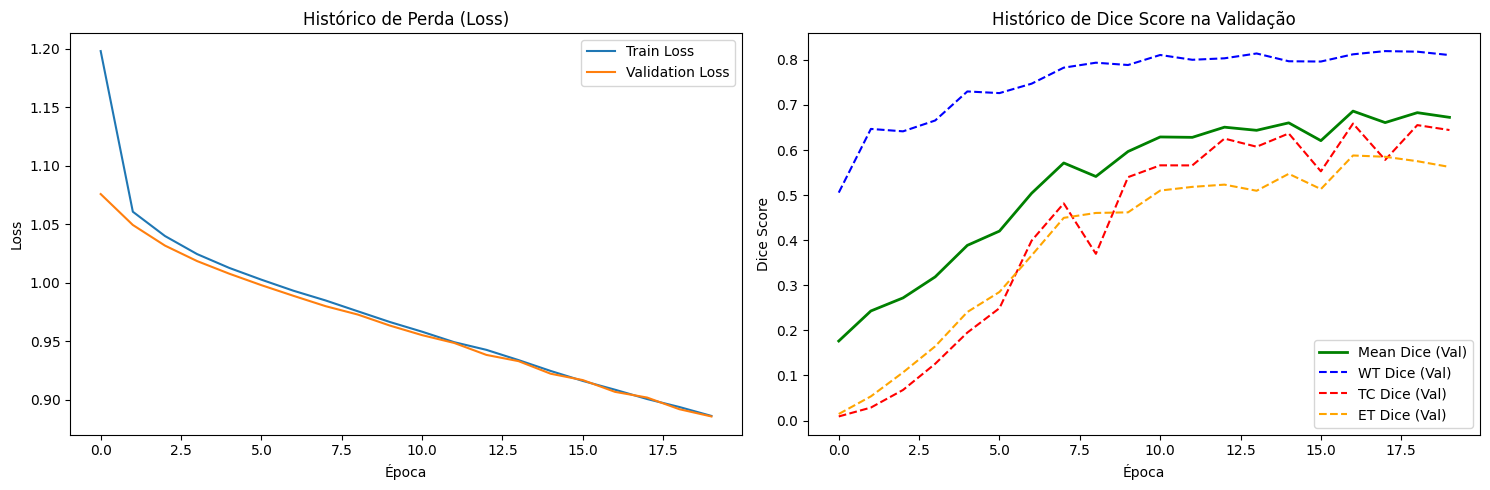

In [47]:
# Plotar métricas após o treinamento
if 'history' in locals():
    plot_training_history(history)

## 8. Inferência e Visualização dos Resultados


In [34]:
best_model_path = '/content/full_training_checkpoints/best_model.pth'

In [39]:
# Instanciar um novo modelo e carregar os pesos
inference_model = UNet3D(in_channels=3, n_classes=4, n_channels=24).to(device)

In [40]:
checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
inference_model.load_state_dict(checkpoint['model_state_dict'])
inference_model.eval()

print(f"Modelo carregado de '{best_model_path}'")

Modelo carregado de '/content/full_training_checkpoints/best_model.pth'


In [37]:
# 2. Criar um DataLoader para o conjunto de teste
test_dataset = BraTSDataset(test_patients, train_patients_data, best_modalities)
test_loader = DataLoader(
    test_dataset,
    batch_size=1, # Processar um paciente de cada vez na inferência
    shuffle=False,
    num_workers=full_config.get('num_workers', 0),
    pin_memory=True
)

print(f"Dataset de teste pronto com {len(test_loader)} pacientes.")


Dataset de teste pronto com 45 pacientes.


In [102]:

class InferenceEngine:
    """Motor de inferência para segmentação de tumores cerebrais"""

    def __init__(self, model, device, metrics_calculator, class_names=None):
        self.model = model
        self.device = device
        self.metrics_calculator = metrics_calculator
        self.class_names = class_names or ['Background', 'NCR/NET', 'Edema', 'Enhancing']

    def predict(self, input_data):
        """Faz predição em um volume de entrada"""
        self.model.eval()
        with torch.no_grad():
            if input_data.dim() == 4:
                input_data = input_data.unsqueeze(0)
            input_data = input_data.to(self.device)
            outputs = self.model(input_data)
            probs = F.softmax(outputs, dim=1)
            predictions = torch.argmax(probs, dim=1)
            # Retornar logits também para as métricas
            return predictions.cpu().numpy(), outputs.cpu()

    def visualize_slice(self, input_volume, prediction, ground_truth=None,
                       slice_idx=None, modality_idx=1, figsize=(20, 10), show_legend=True,
                       metrics=None, show_metrics_table=True):
        """
        Visualiza uma fatia específica da segmentação com cores consistentes,
        comparação de acertos/erros e tabela de métricas.
        """
        if slice_idx is None:
            slice_idx = input_volume.shape[-1] // 2

        input_slice = input_volume[modality_idx, :, :, slice_idx]
        pred_slice = prediction[0, :, :, slice_idx]

        # Definir cores personalizadas para cada classe
        colors = ['#00000000',  # transparente para background
                  '#8A2BE2',    # roxo/azul para NCR/NET
                  '#20B2AA',    # LightSeaGreen para Edema
                  '#F0E68C']    # Khaki para Enhancing

        custom_cmap = ListedColormap(colors)

        # Cores para comparação (acerto/erro)
        comparison_colors = ['#00000000',  # transparente para background
                           '#00FF00',      # verde para acerto
                           '#FF0000']      # vermelho para erro
        comparison_cmap = ListedColormap(comparison_colors)

        # Determinar número de subplots
        num_plots = 4 if ground_truth is not None else 2

        # Criar figura com layout personalizado se mostrar tabela
        if show_metrics_table and metrics is not None and ground_truth is not None:
            fig = plt.figure(figsize=figsize)
            gs = GridSpec(2, 4, figure=fig, height_ratios=[3, 1], hspace=0.3)

            # Subplots principais
            ax1 = fig.add_subplot(gs[0, 0])  # Imagem Original
            ax2 = fig.add_subplot(gs[0, 1])  # Predição
            ax3 = fig.add_subplot(gs[0, 2])  # Ground Truth
            ax4 = fig.add_subplot(gs[0, 3])  # Comparação
            ax_table = fig.add_subplot(gs[1, :])  # Tabela

            axes = [ax1, ax2, ax3, ax4]
        else:
            fig, axes = plt.subplots(1, num_plots, figsize=figsize)
            if num_plots == 1:
                axes = [axes]

        # Imagem Original
        axes[0].imshow(input_slice, cmap='gray')
        axes[0].set_title(f'Imagem Original (Fatia {slice_idx})', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Predição com cores personalizadas
        axes[1].imshow(input_slice, cmap='gray', alpha=0.7)
        masked_pred = np.ma.masked_where(pred_slice == 0, pred_slice)
        axes[1].imshow(masked_pred, cmap=custom_cmap, alpha=0.8, vmin=0, vmax=3)
        axes[1].set_title('Predição', fontsize=12, fontweight='bold')
        axes[1].axis('off')

        # Ground Truth e Comparação (se disponível)
        if ground_truth is not None:
            gt_slice = ground_truth[:, :, slice_idx]

            # Ground Truth
            axes[2].imshow(input_slice, cmap='gray', alpha=0.7)
            masked_gt = np.ma.masked_where(gt_slice == 0, gt_slice)
            axes[2].imshow(masked_gt, cmap=custom_cmap, alpha=0.8, vmin=0, vmax=3)
            axes[2].set_title('Ground Truth', fontsize=12, fontweight='bold')
            axes[2].axis('off')

            # Comparação Acerto/Erro
            axes[3].imshow(input_slice, cmap='gray', alpha=0.7)

            # Criar máscara de comparação
            comparison_mask = np.zeros_like(pred_slice)

            # Para cada classe não-background
            for class_id in [1, 2, 3]:
                pred_class = (pred_slice == class_id)
                gt_class = (gt_slice == class_id)

                # Acertos: predição e GT concordam
                correct = pred_class & gt_class
                comparison_mask[correct] = 1  # Verde para acertos

                # Erros: predição diz que é a classe mas GT não concorda
                # ou GT diz que é a classe mas predição não concorda
                false_positive = pred_class & ~gt_class
                false_negative = ~pred_class & gt_class
                errors = false_positive | false_negative
                comparison_mask[errors] = 2  # Vermelho para erros

            masked_comparison = np.ma.masked_where(comparison_mask == 0, comparison_mask)
            axes[3].imshow(masked_comparison, cmap=comparison_cmap, alpha=0.8, vmin=0, vmax=2)
            axes[3].set_title('Acertos vs Erros', fontsize=12, fontweight='bold')
            axes[3].axis('off')

        # Legenda principal
        if show_legend:
            legend_elements = [
                Rectangle((0,0), 1, 1, facecolor='#8A2BE2', label='NCR/NET'),
                Rectangle((0,0), 1, 1, facecolor='#20B2AA', label='Edema'),
                Rectangle((0,0), 1, 1, facecolor='#F0E68C', label='Enhancing')
            ]

            if ground_truth is not None:
                legend_elements.extend([
                    Rectangle((0,0), 1, 1, facecolor='#00FF00', label='Acerto'),
                    Rectangle((0,0), 1, 1, facecolor='#FF0000', label='Erro')
                ])

            fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))

        # Tabela visual de métricas (opcional)
        if show_metrics_table and metrics is not None and ground_truth is not None:
            ax_table.axis('off')

            # Dados simplificados para a tabela
            classes = ['Whole Tumor', 'Tumor Core', 'Enhancing']

            table_data = []
            for class_name in classes:
                key_suffix = class_name.lower().replace(' ', '_')[:2]  # wh->wt, tu->tc, en->et
                if key_suffix == 'wh': key_suffix = 'wt'
                elif key_suffix == 'tu': key_suffix = 'tc'
                elif key_suffix == 'en': key_suffix = 'et'

                precisao = metrics.get(f'precision_{key_suffix}', 0.0)
                dice = metrics.get(f'dice_{key_suffix}', 0.0)
                iou = metrics.get(f'iou_{key_suffix}', 0.0)

                table_data.append([class_name, f"{precisao:.4f}", f"{dice:.4f}", f"{iou:.4f}"])

            table = ax_table.table(
                cellText=table_data,
                colLabels=['CLASSE', 'PRECISÃO', 'DICE', 'IOU'],
                cellLoc='center',
                loc='center',
                colWidths=[0.4, 0.2, 0.2, 0.2]
            )

            # Estilizar tabela
            table.auto_set_font_size(False)
            table.set_fontsize(11)
            table.scale(1, 2)

            # Colorir cabeçalho
            for i in range(4):
                table[(0, i)].set_facecolor('#4472C4')
                table[(0, i)].set_text_props(weight='bold', color='white')

            ax_table.set_title('Métricas por Classe', fontsize=14, fontweight='bold', pad=20)

        plt.tight_layout()
        plt.show()

    def compute_volume_metrics(self, predictions: torch.Tensor, ground_truth: torch.Tensor):
        """
        Calcula métricas simples por classe: Precisão, Dice e IoU
        """
        # Converter para numpy se necessário
        if isinstance(predictions, torch.Tensor):
            pred = predictions.cpu().numpy()
        else:
            pred = predictions

        if isinstance(ground_truth, torch.Tensor):
            gt = ground_truth.cpu().numpy()
        else:
            gt = ground_truth

        # Se predictions tem 5 dimensões [batch, channels, H, W, D], pegar argmax
        if pred.ndim == 5:
            pred = np.argmax(pred, axis=1)[0]  # [H, W, D]
        elif pred.ndim == 4:
            pred = pred[0]  # Remover dimensão batch

        metrics = {}

        # Calcular para cada classe (1: NCR/NET, 2: Edema, 3: Enhancing)
        class_names = ['ncr', 'ed', 'et']

        for i, class_name in enumerate(class_names, 1):
            # Máscaras binárias para a classe
            pred_mask = (pred == i).astype(np.float32)
            gt_mask = (gt == i).astype(np.float32)

            # True Positives, False Positives, False Negatives
            tp = np.sum(pred_mask * gt_mask)
            fp = np.sum(pred_mask * (1 - gt_mask))
            fn = np.sum((1 - pred_mask) * gt_mask)

            # Precisão
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

            # Recall (Sensibilidade)
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0

            # Dice Score
            dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0

            # IoU (Jaccard)
            iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

            # Armazenar métricas
            metrics[f'precision_{class_name}'] = precision
            metrics[f'recall_{class_name}'] = recall
            metrics[f'dice_{class_name}'] = dice
            metrics[f'iou_{class_name}'] = iou

        # Calcular métricas para regiões compostas BraTS
        # Whole Tumor (WT) = classes 1, 2, 3
        pred_wt = ((pred == 1) | (pred == 2) | (pred == 3)).astype(np.float32)
        gt_wt = ((gt == 1) | (gt == 2) | (gt == 3)).astype(np.float32)

        # Tumor Core (TC) = classes 1, 3
        pred_tc = ((pred == 1) | (pred == 3)).astype(np.float32)
        gt_tc = ((gt == 1) | (gt == 3)).astype(np.float32)

        # Enhancing Tumor (ET) = classe 3
        pred_et = (pred == 3).astype(np.float32)
        gt_et = (gt == 3).astype(np.float32)

        # Calcular métricas para regiões compostas
        for region_name, pred_region, gt_region in [('wt', pred_wt, gt_wt),
                                                    ('tc', pred_tc, gt_tc),
                                                    ('et', pred_et, gt_et)]:
            tp = np.sum(pred_region * gt_region)
            fp = np.sum(pred_region * (1 - gt_region))
            fn = np.sum((1 - pred_region) * gt_region)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
            iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

            metrics[f'precision_{region_name}'] = precision
            metrics[f'recall_{region_name}'] = recall
            metrics[f'dice_{region_name}'] = dice
            metrics[f'iou_{region_name}'] = iou

        return metrics

    def save_prediction(self, prediction, output_path, reference_nii_path=None):
        """Salva predição como arquivo NIfTI """
        pred_volume = prediction[0].astype(np.uint8)
        if reference_nii_path:
            ref_img = nib.load(reference_nii_path)
            pred_img = nib.Nifti1Image(pred_volume, ref_img.affine, ref_img.header)
        else:
            pred_img = nib.Nifti1Image(pred_volume, np.eye(4))
        nib.save(pred_img, output_path)
        print(f"Predição salva em: {output_path}")

    def evaluate_multiple_slices(self, input_volume, prediction, ground_truth,
                                slice_indices=None, modality_idx=1, metrics=None):
        """
        Avalia e visualiza múltiplas fatias com tabela de métricas simples
        """
        if slice_indices is None:
            center = input_volume.shape[-1] // 2
            slice_indices = [center-1, center, center+1]

        # Exibir tabela simples de métricas
        if metrics:
            self._print_metrics_table(metrics)

        print(f"Visualizando fatias centrais: {slice_indices}")

        for slice_idx in slice_indices:
            print(f"\n--- Fatia {slice_idx} ---")
            self.visualize_slice(
                input_volume=input_volume,
                prediction=prediction,
                ground_truth=ground_truth,
                slice_idx=slice_idx,
                modality_idx=modality_idx,
                show_metrics_table=False  # Não mostrar tabela visual nas fatias
            )

    def _print_metrics_table(self, metrics):
        """
        Imprime uma tabela simples de métricas no console
        """
        print("\n" + "="*50)
        print(f"{'CLASSE':<15} | {'PRECISÃO':<10} | {'DICE':<8} | {'IOU':<8}")
        print("="*50)

        # Mapear métricas para as classes principais
        classes_data = [
            ("Whole Tumor", metrics.get('precision_wt', 0.0), metrics.get('dice_wt', 0.0), metrics.get('iou_wt', 0.0)),
            ("Tumor Core", metrics.get('precision_tc', 0.0), metrics.get('dice_tc', 0.0), metrics.get('iou_tc', 0.0)),
            ("Enhancing", metrics.get('precision_et', 0.0), metrics.get('dice_et', 0.0), metrics.get('iou_et', 0.0))
        ]

        for classe, precisao, dice, iou in classes_data:
            print(f"{classe:<15} | {precisao:<10.4f} | {dice:<8.4f} | {iou:<8.4f}")

        print("="*50 + "\n")

In [110]:
def test_inference(model, val_loader, device, num_samples=3):
    """
    Testa a inferência e, para cada amostra, visualiza as 3 fatias
    mais centrais do tumor.
    """
    # Criar InferenceEngine sem metrics_calculator externo
    inference_engine = InferenceEngine(
        model=model,
        device=device,
        metrics_calculator=None,  # Não precisamos mais
        class_names=['Background', 'NCR/NET', 'Edema', 'Enhancing']
    )

    print(f"🧠 Iniciando teste de inferência com {num_samples} amostras...")
    print("="*60)

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            if i >= num_samples:
                break

            # Usar sua estrutura de dados original
            data = batch['volume']
            targets = batch['mask']
            patient_id = batch['patient_id'][0]

            # Fazer predição
            predictions_map, logits = inference_engine.predict(data)

            print(f"\n--- Amostra {i+1}: Paciente {patient_id} ---")

            # Calcular métricas usando o novo método
            metrics = inference_engine.compute_volume_metrics(
                predictions=torch.from_numpy(predictions_map),
                ground_truth=targets[0]
            )

            # Exibir tabela de métricas no console
            inference_engine._print_metrics_table(metrics)

            # Encontrar fatia central baseada no tumor
            gt_mask_numpy = targets[0].numpy()
            tumor_indices = np.where(gt_mask_numpy > 0)

            if len(tumor_indices[0]) > 0:
                central_slice_idx = int(np.median(tumor_indices[2]))
            else:
                central_slice_idx = data.shape[-1] // 2

            # Definir as 3 fatias BEM CENTRAIS que queremos visualizar
            slice_indices = [
                max(0, central_slice_idx - 1),  # A fatia imediatamente antes do centro
                central_slice_idx,              # A fatia central
                min(data.shape[-1] - 1, central_slice_idx + 1) # A fatia imediatamente depois do centro
            ]

            # Remover duplicatas caso o tumor esteja no início ou fim do volume
            slice_indices = sorted(list(set(slice_indices)))

            print(f"Visualizando fatias centrais: {slice_indices}")

            for j, slice_idx in enumerate(slice_indices):
                print(f"\n--- Fatia {slice_idx} ---")

                # A variável show_legend será True apenas para o primeiro item (j=0)
                show_legend_flag = (j == 0)

                inference_engine.visualize_slice(
                    input_volume=data[0].numpy(),
                    prediction=predictions_map,
                    ground_truth=targets[0].numpy(),
                    slice_idx=slice_idx,
                    modality_idx=1,
                    show_legend=show_legend_flag,
                    show_metrics_table=False  # Não mostrar tabela visual nas fatias
                )

    print(f"\n✅ Teste de inferência concluído! Processadas {num_samples} amostras.")


🧠 Iniciando teste de inferência com 3 amostras...

--- Amostra 1: Paciente BraTS20_Training_278 ---

CLASSE          | PRECISÃO   | DICE     | IOU     
Whole Tumor     | 0.6479     | 0.7710   | 0.6274  
Tumor Core      | 0.8471     | 0.4926   | 0.3268  
Enhancing       | 0.0000     | 0.0000   | 0.0000  

Visualizando fatias centrais: [31, 32, 33]

--- Fatia 31 ---


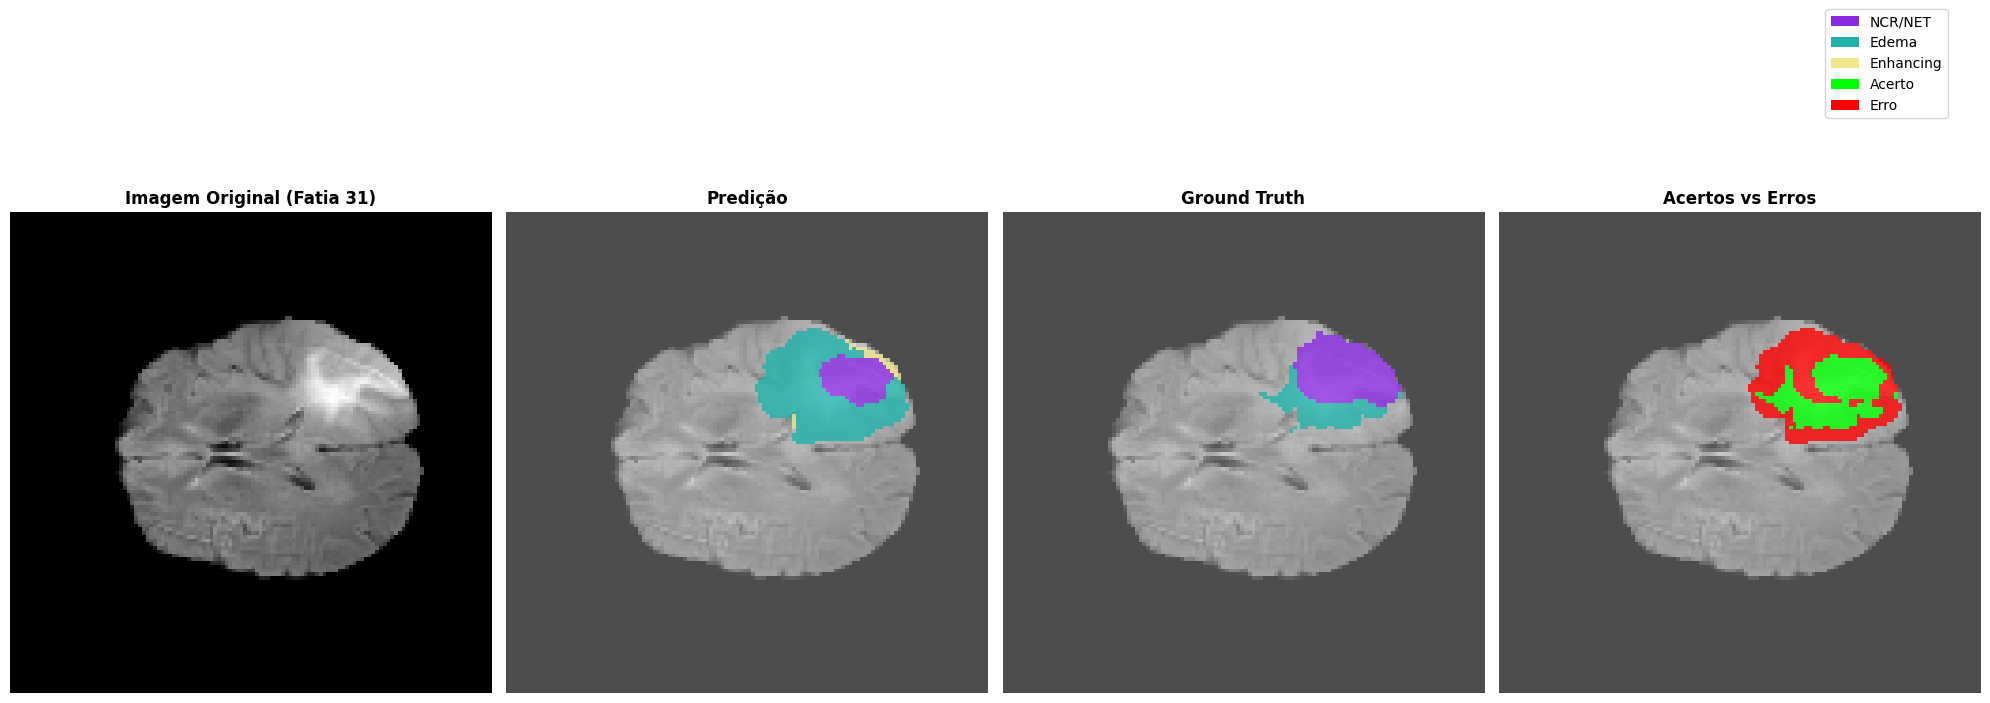


--- Fatia 32 ---


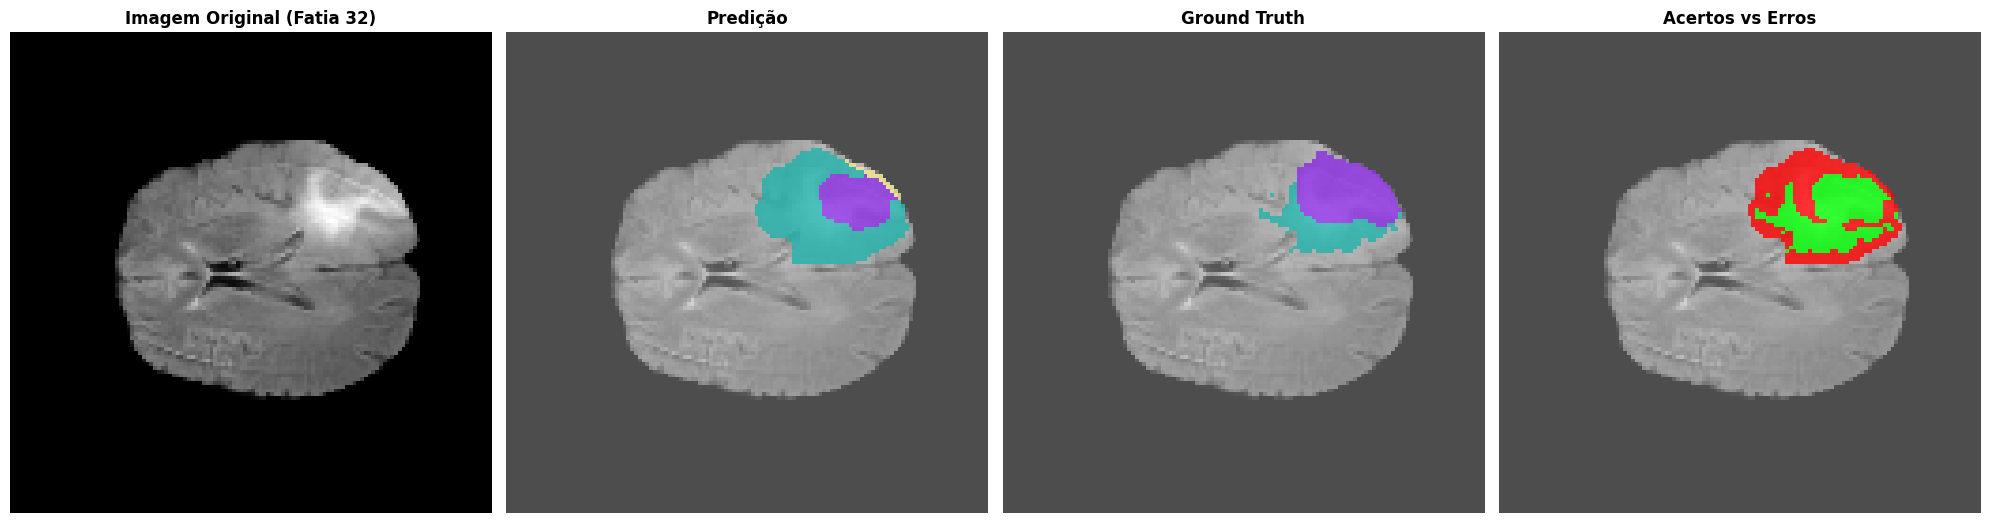


--- Fatia 33 ---


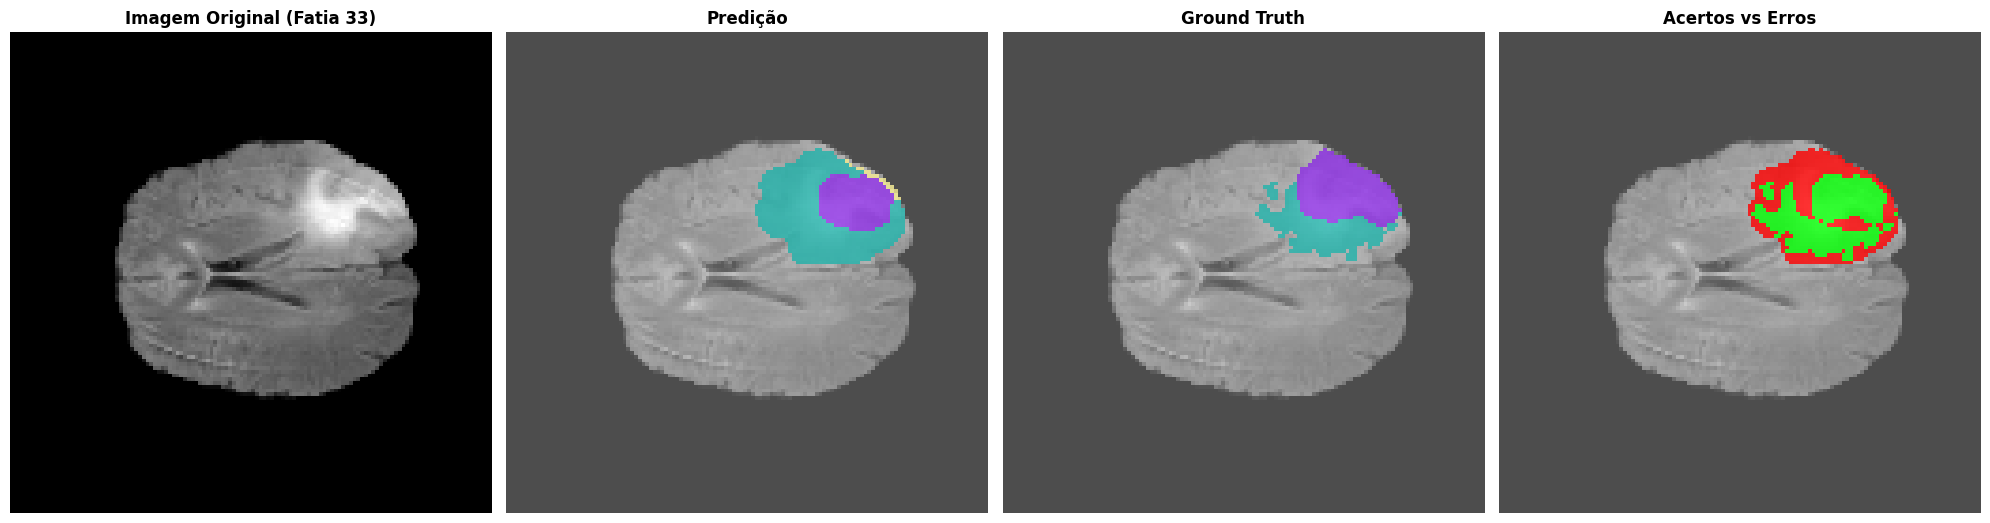


--- Amostra 2: Paciente BraTS20_Training_090 ---

CLASSE          | PRECISÃO   | DICE     | IOU     
Whole Tumor     | 0.5946     | 0.7384   | 0.5853  
Tumor Core      | 0.5734     | 0.6259   | 0.4555  
Enhancing       | 0.3833     | 0.4904   | 0.3248  

Visualizando fatias centrais: [31, 32, 33]

--- Fatia 31 ---


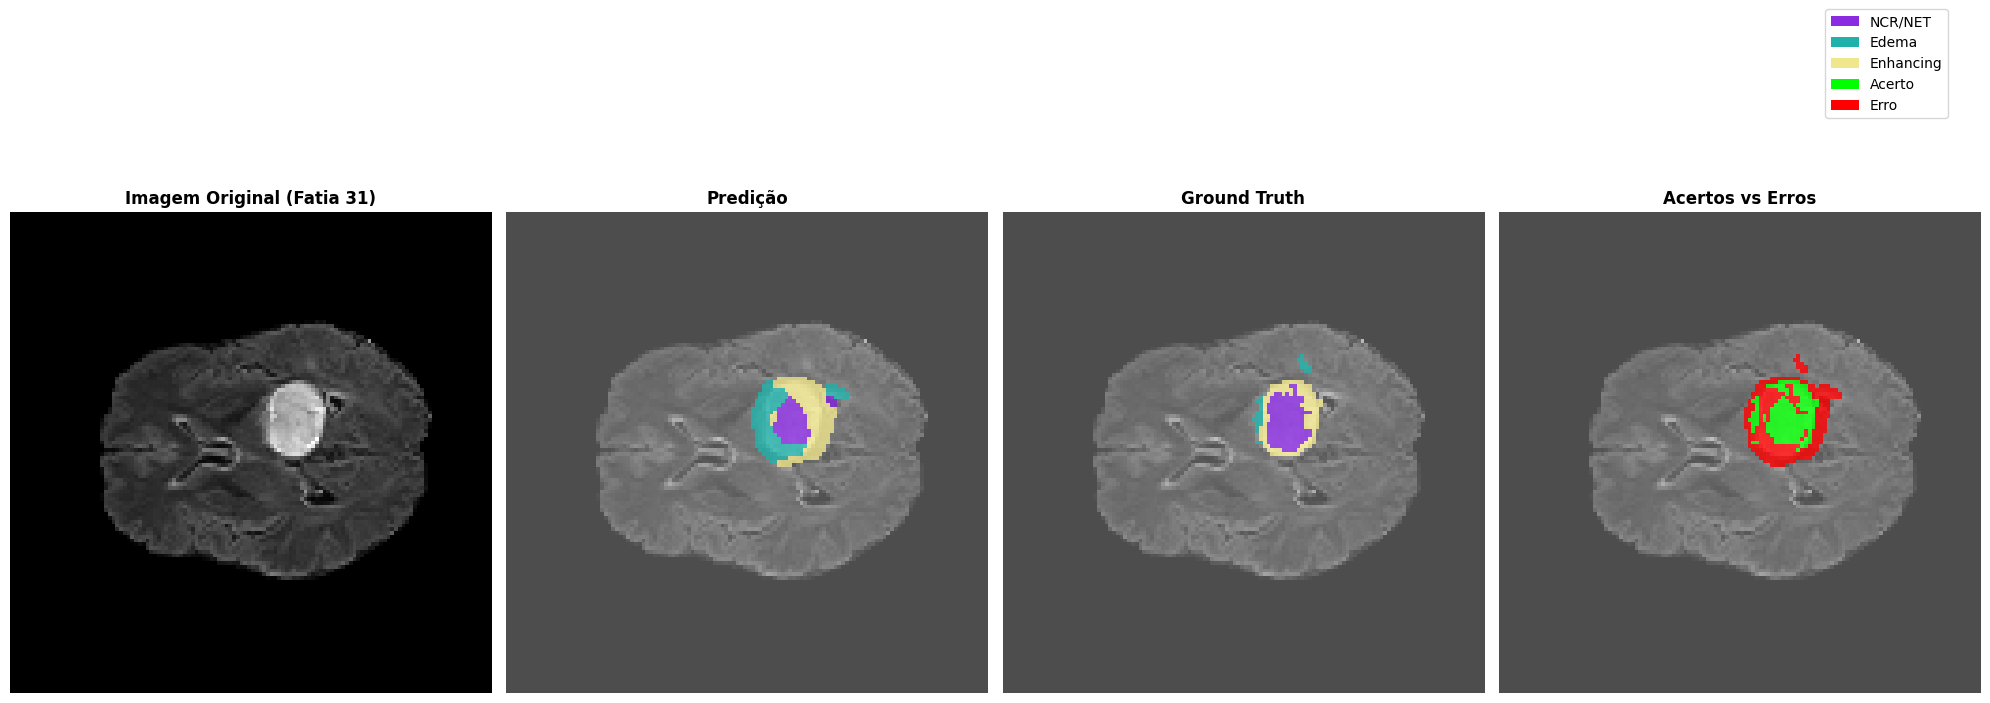


--- Fatia 32 ---


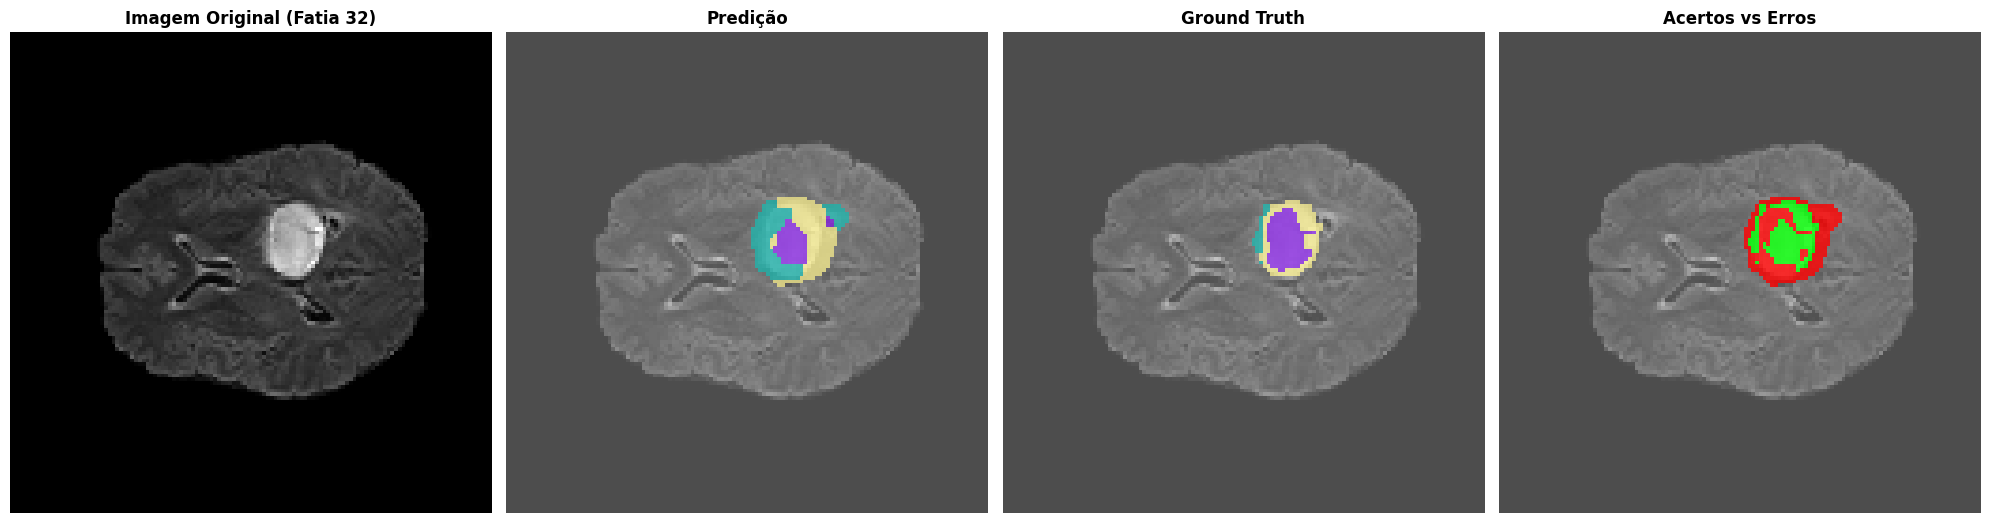


--- Fatia 33 ---


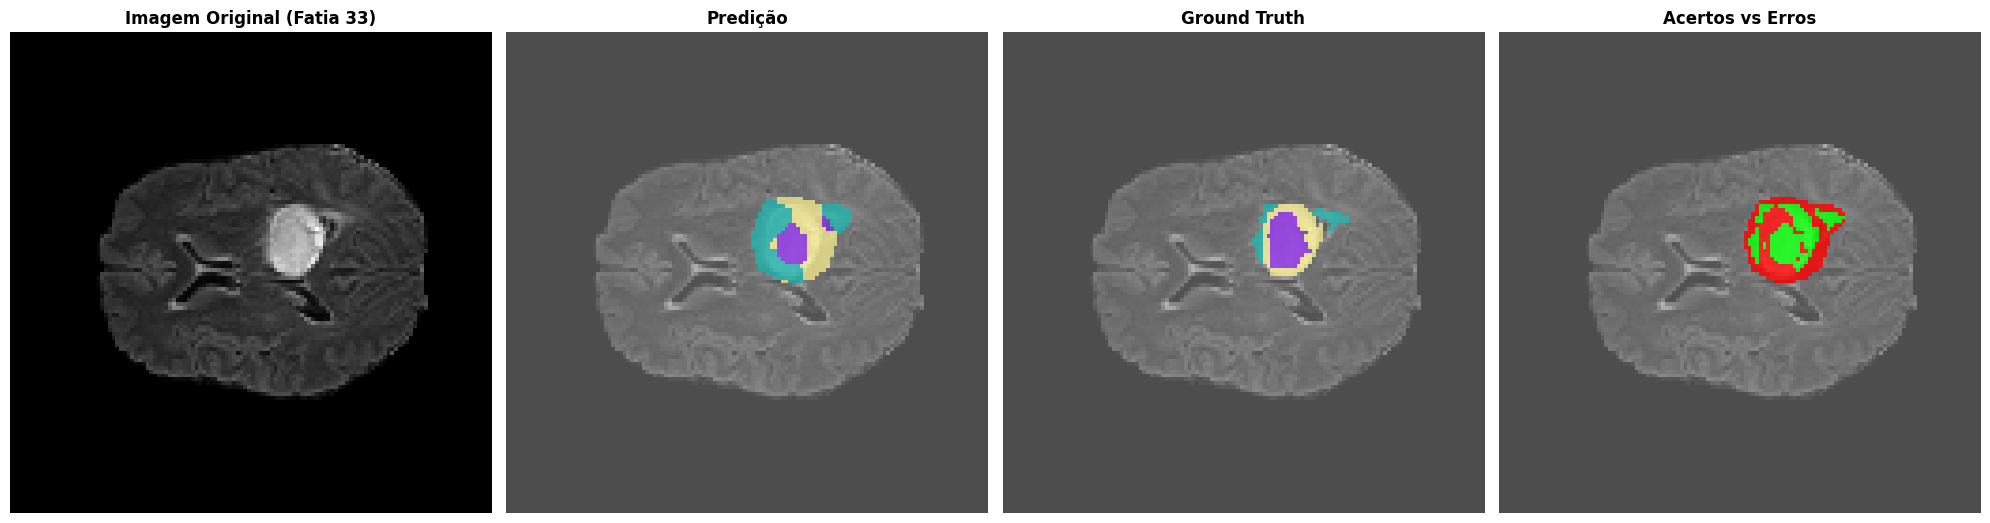


--- Amostra 3: Paciente BraTS20_Training_064 ---

CLASSE          | PRECISÃO   | DICE     | IOU     
Whole Tumor     | 0.7299     | 0.8138   | 0.6861  
Tumor Core      | 0.8703     | 0.6225   | 0.4519  
Enhancing       | 0.5593     | 0.4853   | 0.3204  

Visualizando fatias centrais: [23, 24, 25]

--- Fatia 23 ---


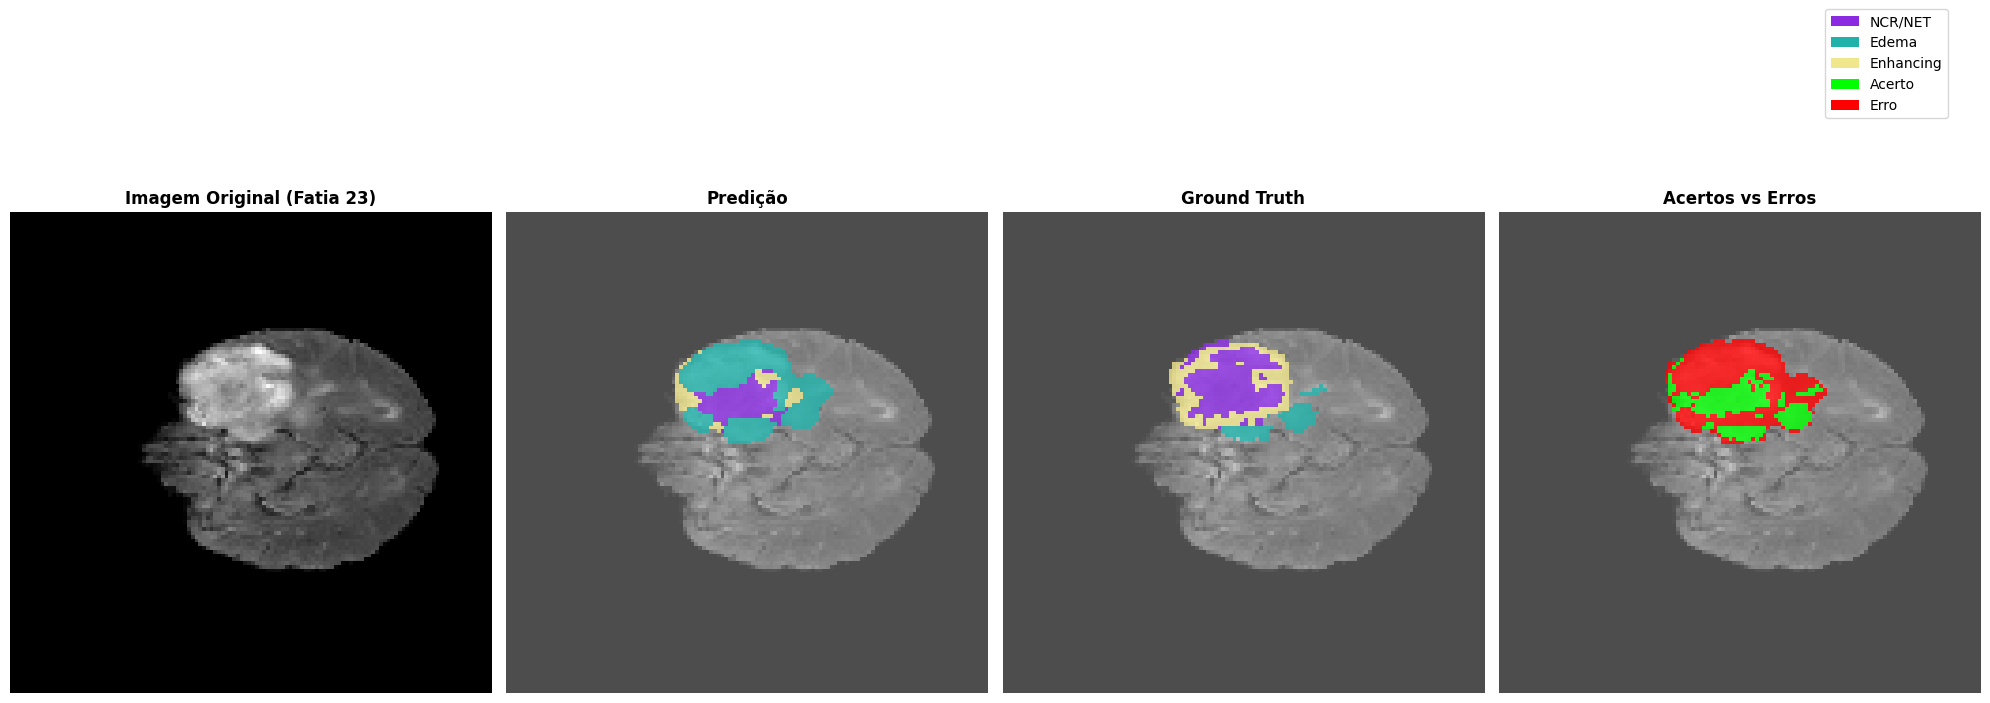


--- Fatia 24 ---


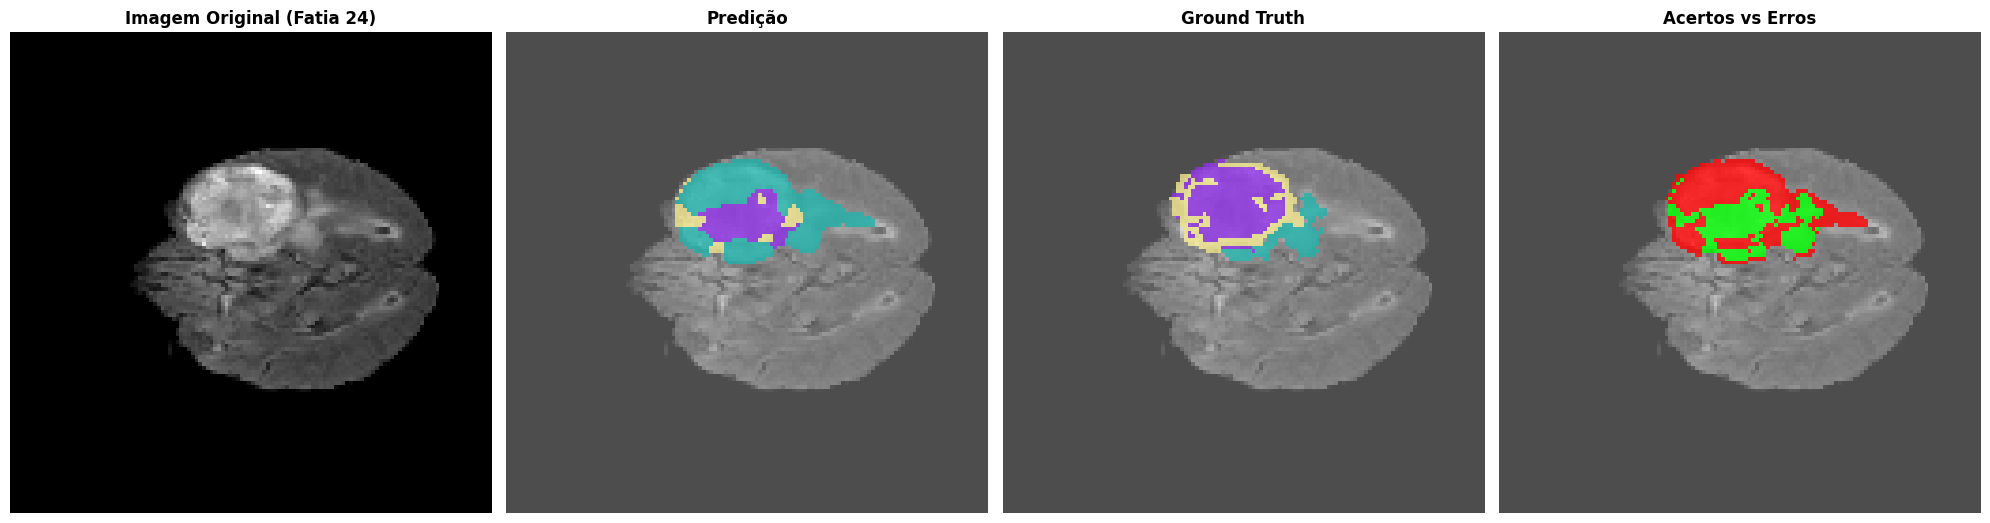


--- Fatia 25 ---


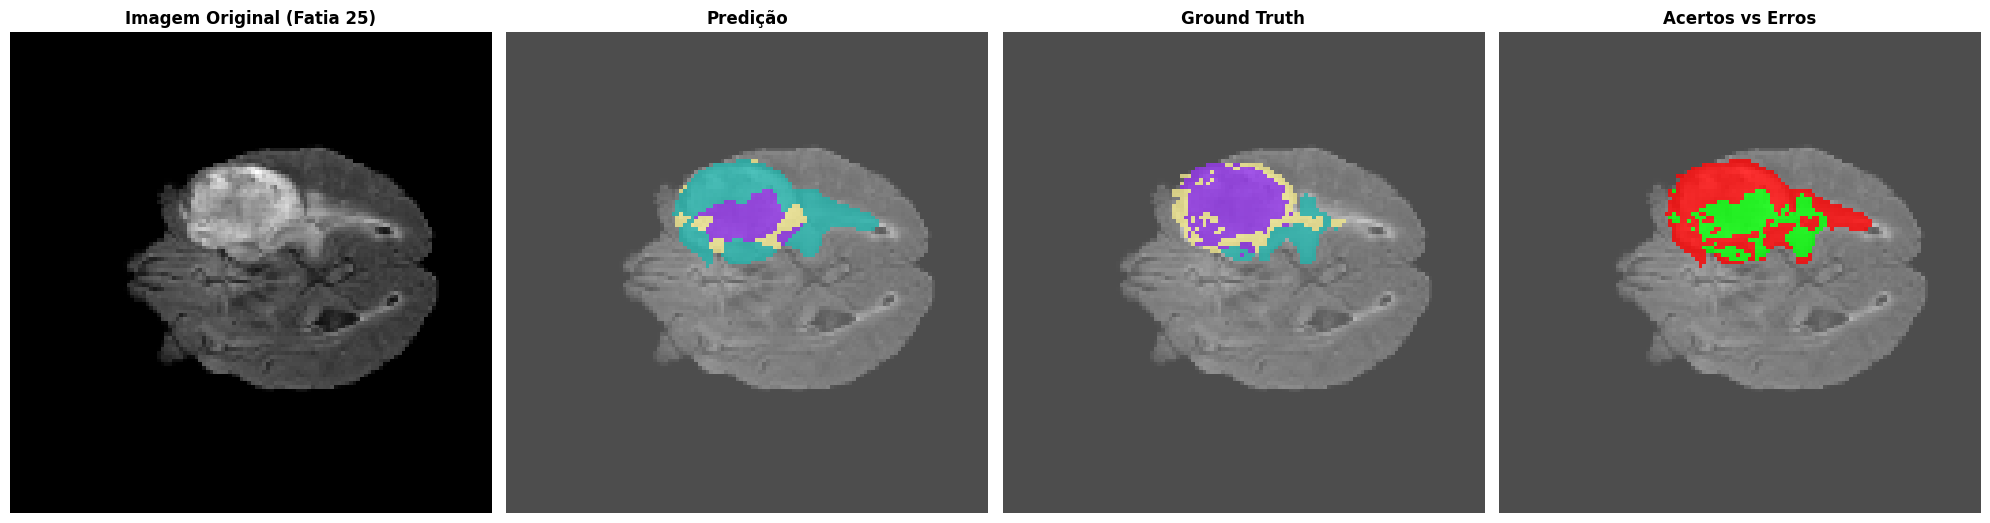


✅ Teste de inferência concluído! Processadas 3 amostras.


In [111]:
test_inference(
    model=inference_model,
    val_loader=test_loader,
    device=device,
    num_samples=3
)